# Case and Simulation studies based on ABIDE data

## Kai Yang
## <kai.yang2 "at" mail.mcgill.ca>
## [GPG Public key Fingerprint: B9F863A56220DBD56B91C3E835022A1A5941D810](https://keys.openpgp.org/vks/v1/by-fingerprint/B9F863A56220DBD56B91C3E835022A1A5941D810)

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import multiprocess as mp
import numpy as np
import pandas as pd

# from dask import dataframe as dd
from scipy.linalg import block_diag, toeplitz
from scipy.stats import kendalltau, norm, rankdata
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import (
    ElasticNetCV,
    LarsCV,
    LassoCV,
    LassoLarsCV,
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
    RidgeCV,
)
from sklearn.metrics import r2_score, roc_auc_score

# import fastHDMI as mi # I comment out since I am running the Jupyter notebook on my M1 Macbook air
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import SplineTransformer, StandardScaler
from tqdm import tqdm

plt.style.use("ggplot")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.sans-serif": ["Times New Roman"],
    "font.size": 12,
})

# os.chdir(sys.path[0])  # ensure working direcotry is set same as the file

# Simulation study for continuous and binary outcome based on ABIDE data, and testing the screening performance for all three methods

## creating job submission scripts for simulation study

### simulating *nonlinear* outcomes/predictors

In [2]:
from pathlib import Path


def job_generator(outcome, num_true_vars_iter):
    py_1 = r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os
import itertools

# read the data
csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"

abide_original = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
_abide_name = abide_original.columns.tolist()[1:]

# print(_abide_name)

abide_name_original = _abide_name[1:-3]

# preserve only the neuro-imaging data
abide_original = abide_original[abide_name_original]

def convert2list(a):
    b = np.asarray(a)
    return b.tolist()
"""
    if outcome == "continuous":
        py_2 = r"""
def sim_based_on_abide_continuous(pair):
    abide, abide_name = abide_original.copy(), abide_name_original.copy()
    _num_true_vars, _seed = pair
    SNR = 3.
    num_true_vars = _num_true_vars
    seed = _seed
    assert num_true_vars < len(abide_name)
    np.random.seed(seed)

    true_attr_label = np.zeros(len(abide_name), dtype=int)
    true_attr_index = np.arange(len(abide_name))
    true_attr_index = np.random.choice(true_attr_index,
                                       num_true_vars,
                                       replace=False)
    true_names = np.take(abide_name,
                         true_attr_index)  # this is a list for true names
    true_names = convert2list(true_names)
    true_attr_label[
        true_attr_index] = 1  # true_attr_label is binary indicate whether the covaraite is "true"

    mean = np.ones(num_true_vars)*6.
    true_beta_cov = toeplitz(0.6**np.arange(num_true_vars))
    true_beta = np.random.multivariate_normal(mean, true_beta_cov, 1).flatten()
    # true_beta = np.random.choice([1., -1.], num_true_vars, replace=True)
    #     true_beta = np.random.uniform(low=5.0, high=6.0,
    #                                   size=num_true_vars) * np.random.choice(
    #                                       [1., -1.], num_true_vars, replace=True)

    sim_data = abide[true_names].to_numpy(copy=True)
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    sim_data = sim_data**2
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)

    X_cov = np.corrcoef(sim_data, rowvar=False)
    true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)

    outcome = sim_data @ true_beta + np.random.normal(0, true_sigma_sim,
                                                      sim_data.shape[0])

    abide["outcome"] = outcome
    abide = abide[["outcome"] + abide_name]

    print("The outcome is continuous.")

    print("Our developed FFT-based MI calculation:")

    try:
        mi_output = mi.continuous_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="ISJ",
            norm=2)
    except:
        mi_output = mi.continuous_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="silverman",
            norm=2)

    print("Our developed binning MI calculation:")

    binning_mi_output = mi.binning_continuous_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    print("sklearn MI calculation:")

    skmi_output = mi.continuous_skMI_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        random_state=0,
        share_memory=False)

    print("Pearson's correlation calculation:")

    pearson_output = mi.Pearson_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    mi_pseudo_prob = np.abs(mi_output) / np.max(np.abs(mi_output))
    mi_auroc = roc_auc_score(true_attr_label, mi_pseudo_prob)
    binning_mi_pseudo_prob = np.abs(binning_mi_output) / np.max(
        np.abs(binning_mi_output))
    binning_mi_auroc = roc_auc_score(true_attr_label, binning_mi_pseudo_prob)
    skmi_pseudo_prob = np.abs(skmi_output) / np.max(np.abs(skmi_output))
    skmi_auroc = roc_auc_score(true_attr_label, skmi_pseudo_prob)
    pearson_pseudo_prob = np.abs(pearson_output) / np.max(
        np.abs(pearson_output))
    pearson_auroc = roc_auc_score(true_attr_label, pearson_pseudo_prob)

    del mi_output, binning_mi_output, skmi_output, pearson_output, abide, abide_name, true_names, true_beta, sim_data, X_cov, true_sigma_sim, outcome, mi_pseudo_prob, skmi_pseudo_prob, pearson_pseudo_prob

    return np.array([mi_auroc, skmi_auroc, pearson_auroc, binning_mi_auroc])


num_true_vars_list = [{_num_true_vars_iter}]
seed_list = range(100)

itrs = itertools.product(num_true_vars_list, seed_list)

output_array = np.array(list(map(sim_based_on_abide_continuous, tqdm(itrs))))
output_array = output_array.reshape(1, 100, 4).squeeze()
np.save(r"./ABIDE_{_outcome}_{_num_true_vars_iter}", output_array)
""".format(_num_true_vars_iter=num_true_vars_iter, _outcome=outcome)
    elif outcome == "binary_original":
        py_2 = r"""
def sim_based_on_abide_binary(pair):
    abide, abide_name = abide_original.copy(), abide_name_original.copy()
    _num_true_vars, _seed = pair
    num_true_vars = _num_true_vars
    seed = _seed
    assert num_true_vars < len(abide_name)
    np.random.seed(seed)

    true_attr_label = np.zeros(len(abide_name), dtype=int)
    true_attr_index = np.arange(len(abide_name))
    true_attr_index = np.random.choice(true_attr_index,
                                       num_true_vars,
                                       replace=False)
    true_names = np.take(abide_name,
                         true_attr_index)  # this is a list for true names
    true_names = convert2list(true_names)
    true_attr_label[
        true_attr_index] = 1  # true_attr_label is binary indicate whether the covaraite is "true"

    mean = np.ones(num_true_vars)*6.
    true_beta_cov = toeplitz(0.6**np.arange(num_true_vars))
    true_beta = np.random.multivariate_normal(mean, true_beta_cov, 1).flatten()
    # true_beta = np.random.choice([1., -1.], num_true_vars, replace=True)    #     true_beta = np.random.uniform(low=.5, high=.6,
    #                                   size=num_true_vars) * np.random.choice(
    #                                       [1., -1.], num_true_vars, replace=True)

    sim_data = abide[true_names].to_numpy(copy=True)
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    sim_data = sim_data**2
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    signal = sim_data @ true_beta
    signal -= np.mean(
        signal
    )  # make sure it's centered at 0 to avoid generated data all be in one class
    signal /= np.std(signal)  # avoid the case if the data is too centered

    outcome = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5)  # logistic
    # outcome = np.random.binomial(1,
    #                              np.arcsin(np.sqrt(signal + np.min(signal))) /
    #                              (np.pi / 2.))  # arcsin(sqrt(.))

    abide["outcome"] = outcome
    abide = abide[["outcome"] + abide_name]

    print("The outcome is binary.")

    print("Our developed FFT-based MI calculation:")

    try:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="ISJ")
    except:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="silverman")
            
    print("Our developed binning MI calculation:")

    binning_mi_output = mi.binning_binary_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    print("sklearn MI calculation:")

    skmi_output = mi.binary_skMI_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        random_state=0,
        share_memory=False)

    print("Pearson's correlation calculation:")

    pearson_output = mi.Pearson_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    mi_pseudo_prob = np.abs(mi_output) / np.max(np.abs(mi_output))
    mi_auroc = roc_auc_score(true_attr_label, mi_pseudo_prob)
    binning_mi_pseudo_prob = np.abs(binning_mi_output) / np.max(
        np.abs(binning_mi_output))
    binning_mi_auroc = roc_auc_score(true_attr_label, binning_mi_pseudo_prob)
    skmi_pseudo_prob = np.abs(skmi_output) / np.max(np.abs(skmi_output))
    skmi_auroc = roc_auc_score(true_attr_label, skmi_pseudo_prob)
    pearson_pseudo_prob = np.abs(pearson_output) / np.max(
        np.abs(pearson_output))
    pearson_auroc = roc_auc_score(true_attr_label, pearson_pseudo_prob)

    del mi_output, binning_mi_output, skmi_output, pearson_output, abide, abide_name, true_names, true_beta, sim_data, signal, outcome, mi_pseudo_prob, skmi_pseudo_prob, pearson_pseudo_prob

    return np.array([mi_auroc, skmi_auroc, pearson_auroc, binning_mi_auroc])


num_true_vars_list = [{_num_true_vars_iter}]
seed_list = range(100)

itrs = itertools.product(num_true_vars_list, seed_list)

output_array = np.array(list(map(sim_based_on_abide_binary, tqdm(itrs))))
output_array = output_array.reshape(1, 100, 4).squeeze()
np.save(r"./ABIDE_{_outcome}_{_num_true_vars_iter}", output_array)
""".format(_num_true_vars_iter=num_true_vars_iter, _outcome=outcome)

    elif outcome == "binary_translated":
        py_2 = r"""
def sim_based_on_abide_binary(pair):
    abide, abide_name = abide_original.copy(), abide_name_original.copy()
    _num_true_vars, _seed = pair
    num_true_vars = _num_true_vars
    seed = _seed
    assert num_true_vars < len(abide_name)
    np.random.seed(seed)

    true_attr_label = np.zeros(len(abide_name), dtype=int)
    true_attr_index = np.arange(len(abide_name))
    true_attr_index = np.random.choice(true_attr_index,
                                       num_true_vars,
                                       replace=False)
    true_names = np.take(abide_name,
                         true_attr_index)  # this is a list for true names
    true_names = convert2list(true_names)
    true_attr_label[
        true_attr_index] = 1  # true_attr_label is binary indicate whether the covaraite is "true"

    mean = np.ones(num_true_vars)*6.
    true_beta_cov = toeplitz(0.6**np.arange(num_true_vars))
    true_beta = np.random.multivariate_normal(mean, true_beta_cov, 1).flatten()
    # true_beta = np.random.choice([1., -1.], num_true_vars, replace=True)    #     true_beta = np.random.uniform(low=.5, high=.6,
    #                                   size=num_true_vars) * np.random.choice(
    #                                       [1., -1.], num_true_vars, replace=True)

    sim_data = abide[true_names].to_numpy(copy=True)
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    sim_data = sim_data**2
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    signal = sim_data @ true_beta
    signal -= np.mean(
        signal
    )  # make sure it's centered at 0 to avoid generated data all be in one class
    signal /= np.std(signal)  # avoid the case if the data is too centered
    # this is to make the data centered at the point with highest curvature to archive most nonlinearity
    signal += np.arctanh((1. / 3)**.5)

    outcome = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5)  # logistic
    # outcome = np.random.binomial(1,
    #                              np.arcsin(np.sqrt(signal + np.min(signal))) /
    #                              (np.pi / 2.))  # arcsin(sqrt(.))

    abide["outcome"] = outcome
    abide = abide[["outcome"] + abide_name]

    print("The outcome is binary.")

    print("Our developed FFT-based MI calculation:")

    try:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="ISJ")
    except:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="silverman")

    print("Our developed binning MI calculation:")

    binning_mi_output = mi.binning_binary_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    print("sklearn MI calculation:")

    skmi_output = mi.binary_skMI_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        random_state=0,
        share_memory=False)

    print("Pearson's correlation calculation:")

    pearson_output = mi.Pearson_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    mi_pseudo_prob = np.abs(mi_output) / np.max(np.abs(mi_output))
    mi_auroc = roc_auc_score(true_attr_label, mi_pseudo_prob)
    binning_mi_pseudo_prob = np.abs(binning_mi_output) / np.max(
        np.abs(binning_mi_output))
    binning_mi_auroc = roc_auc_score(true_attr_label, binning_mi_pseudo_prob)
    skmi_pseudo_prob = np.abs(skmi_output) / np.max(np.abs(skmi_output))
    skmi_auroc = roc_auc_score(true_attr_label, skmi_pseudo_prob)
    pearson_pseudo_prob = np.abs(pearson_output) / np.max(
        np.abs(pearson_output))
    pearson_auroc = roc_auc_score(true_attr_label, pearson_pseudo_prob)

    del mi_output, binning_mi_output, skmi_output, pearson_output, abide, abide_name, true_names, true_beta, sim_data, signal, outcome, mi_pseudo_prob, skmi_pseudo_prob, pearson_pseudo_prob

    return np.array([mi_auroc, skmi_auroc, pearson_auroc, binning_mi_auroc])


num_true_vars_list = [{_num_true_vars_iter}]
seed_list = range(100)

itrs = itertools.product(num_true_vars_list, seed_list)

output_array = np.array(list(map(sim_based_on_abide_binary, tqdm(itrs))))
output_array = output_array.reshape(1, 100, 4).squeeze()
np.save(r"./ABIDE_{_outcome}_{_num_true_vars_iter}", output_array)
""".format(_num_true_vars_iter=num_true_vars_iter, _outcome=outcome)

    Path(r"./ABIDE_simulations_nonlinear/ABIDE_sim_" + outcome +
         r"_{_num_true_vars_iter}".format(
             _num_true_vars_iter=num_true_vars_iter) + ".py").touch()
    py_script = open(
        r"./ABIDE_simulations_nonlinear/ABIDE_sim_" + outcome +
        r"_{_num_true_vars_iter}".format(
            _num_true_vars_iter=num_true_vars_iter) + ".py",
        "w",
    )
    py_script.write(py_1 + py_2)

    Path(r"./ABIDE_simulations_nonlinear/ABIDE_sim_" + outcome +
         r"_{_num_true_vars_iter}".format(
             _num_true_vars_iter=num_true_vars_iter) + ".sh").touch()
    bash_script = open(
        r"./ABIDE_simulations_nonlinear/ABIDE_sim_" + outcome +
        r"_{_num_true_vars_iter}".format(
            _num_true_vars_iter=num_true_vars_iter) + ".sh",
        "w",
    )
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=32
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name={outcome}_{_num_true_vars_iter}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os
import itertools

nvidia-smi
lscpu

echo "running ABIDE_sim_{outcome}_{_num_true_vars_iter}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/

python3 ABIDE_sim_{outcome}_{_num_true_vars_iter}.py
""".format(outcome=outcome, _num_true_vars_iter=num_true_vars_iter))


num_true_vars_list = list(map(int, np.linspace(0, 200,
                                               6)))[1:]  # we don't want 0 here

for outcome in ["continuous", "binary_original", "binary_translated"]:
    for num_true_vars_iter in num_true_vars_list:
        job_generator(outcome=outcome, num_true_vars_iter=num_true_vars_iter)

### simulating *linear* outcomes/predictors

In [3]:
from pathlib import Path


def job_generator(outcome, num_true_vars_iter):
    py_1 = r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os
import itertools

# read the data
csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"

abide_original = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
_abide_name = abide_original.columns.tolist()[1:]

# print(_abide_name)

abide_name_original = _abide_name[1:-3]

# preserve only the neuro-imaging data
abide_original = abide_original[abide_name_original]

def convert2list(a):
    b = np.asarray(a)
    return b.tolist()
"""
    if outcome == "continuous":
        py_2 = r"""
def sim_based_on_abide_continuous(pair):
    abide, abide_name = abide_original.copy(), abide_name_original.copy()
    _num_true_vars, _seed = pair
    SNR = 3.
    num_true_vars = _num_true_vars
    seed = _seed
    assert num_true_vars < len(abide_name)
    np.random.seed(seed)

    true_attr_label = np.zeros(len(abide_name), dtype=int)
    true_attr_index = np.arange(len(abide_name))
    true_attr_index = np.random.choice(true_attr_index,
                                       num_true_vars,
                                       replace=False)
    true_names = np.take(abide_name,
                         true_attr_index)  # this is a list for true names
    true_names = convert2list(true_names)
    true_attr_label[
        true_attr_index] = 1  # true_attr_label is binary indicate whether the covaraite is "true"

    mean = np.ones(num_true_vars)*6.
    true_beta_cov = toeplitz(0.6**np.arange(num_true_vars))
    true_beta = np.random.multivariate_normal(mean, true_beta_cov, 1).flatten()
    # true_beta = np.random.choice([1., -1.], num_true_vars, replace=True)    #     true_beta = np.random.uniform(low=5.0, high=6.0,
    #                                   size=num_true_vars) * np.random.choice(
    #                                       [1., -1.], num_true_vars, replace=True)

    sim_data = abide[true_names].to_numpy(copy=True)
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)

    X_cov = np.corrcoef(sim_data, rowvar=False)
    true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)

    outcome = sim_data @ true_beta + np.random.normal(0, true_sigma_sim,
                                                      sim_data.shape[0])

    abide["outcome"] = outcome
    abide = abide[["outcome"] + abide_name]

    print("The outcome is continuous.")

    print("Our developed FFT-based MI calculation:")

    try:
        mi_output = mi.continuous_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="ISJ",
            norm=2)
    except:
        mi_output = mi.continuous_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="silverman",
            norm=2)
    
    print("Our developed binning MI calculation:")

    binning_mi_output = mi.binning_continuous_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    print("sklearn MI calculation:")

    skmi_output = mi.continuous_skMI_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        random_state=0,
        share_memory=False)

    print("Pearson's correlation calculation:")

    pearson_output = mi.Pearson_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    mi_pseudo_prob = np.abs(mi_output) / np.max(np.abs(mi_output))
    mi_auroc = roc_auc_score(true_attr_label, mi_pseudo_prob)
    binning_mi_pseudo_prob = np.abs(binning_mi_output) / np.max(
        np.abs(binning_mi_output))
    binning_mi_auroc = roc_auc_score(true_attr_label, binning_mi_pseudo_prob)
    skmi_pseudo_prob = np.abs(skmi_output) / np.max(np.abs(skmi_output))
    skmi_auroc = roc_auc_score(true_attr_label, skmi_pseudo_prob)
    pearson_pseudo_prob = np.abs(pearson_output) / np.max(
        np.abs(pearson_output))
    pearson_auroc = roc_auc_score(true_attr_label, pearson_pseudo_prob)

    del mi_output,binning_mi_output, skmi_output, pearson_output, abide, abide_name, true_names, true_beta, sim_data, X_cov, true_sigma_sim, outcome, mi_pseudo_prob, skmi_pseudo_prob, pearson_pseudo_prob

    return np.array([mi_auroc, skmi_auroc, pearson_auroc, binning_mi_auroc])


num_true_vars_list = [{_num_true_vars_iter}]
seed_list = range(100)

itrs = itertools.product(num_true_vars_list, seed_list)

output_array = np.array(list(map(sim_based_on_abide_continuous, tqdm(itrs))))
output_array = output_array.reshape(1, 100, 4).squeeze()
np.save(r"./ABIDE_{_outcome}_{_num_true_vars_iter}", output_array)
""".format(_num_true_vars_iter=num_true_vars_iter, _outcome=outcome)
    elif outcome == "binary_original":
        py_2 = r"""
def sim_based_on_abide_binary(pair):
    abide, abide_name = abide_original.copy(), abide_name_original.copy()
    _num_true_vars, _seed = pair
    num_true_vars = _num_true_vars
    seed = _seed
    assert num_true_vars < len(abide_name)
    np.random.seed(seed)

    true_attr_label = np.zeros(len(abide_name), dtype=int)
    true_attr_index = np.arange(len(abide_name))
    true_attr_index = np.random.choice(true_attr_index,
                                       num_true_vars,
                                       replace=False)
    true_names = np.take(abide_name,
                         true_attr_index)  # this is a list for true names
    true_names = convert2list(true_names)
    true_attr_label[
        true_attr_index] = 1  # true_attr_label is binary indicate whether the covaraite is "true"

    mean = np.ones(num_true_vars)*6.
    true_beta_cov = toeplitz(0.6**np.arange(num_true_vars))
    true_beta = np.random.multivariate_normal(mean, true_beta_cov, 1).flatten()
    # true_beta = np.random.choice([1., -1.], num_true_vars, replace=True)    #     true_beta = np.random.uniform(low=.5, high=.6,
    #                                   size=num_true_vars) * np.random.choice(
    #                                       [1., -1.], num_true_vars, replace=True)

    sim_data = abide[true_names].to_numpy(copy=True)
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    signal = sim_data @ true_beta
    signal -= np.mean(
        signal
    )  # make sure it's centered at 0 to avoid generated data all be in one class
    signal /= np.std(signal)  # avoid the case if the data is too centered

    outcome = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5) # logistic
    # outcome = np.random.binomial(1,
    #                              np.arcsin(np.sqrt(signal + np.min(signal))) /
    #                              (np.pi / 2.))  # arcsin(sqrt(.))

    abide["outcome"] = outcome
    abide = abide[["outcome"] + abide_name]

    print("The outcome is binary.")

    print("Our developed FFT-based MI calculation:")

    try:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="ISJ")
    except:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="silverman")

    print("Our developed binning MI calculation:")

    binning_mi_output = mi.binning_binary_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    print("sklearn MI calculation:")

    skmi_output = mi.binary_skMI_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        random_state=0,
        share_memory=False)

    print("Pearson's correlation calculation:")

    pearson_output = mi.Pearson_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    mi_pseudo_prob = np.abs(mi_output) / np.max(np.abs(mi_output))
    mi_auroc = roc_auc_score(true_attr_label, mi_pseudo_prob)
    binning_mi_pseudo_prob = np.abs(binning_mi_output) / np.max(
        np.abs(binning_mi_output))
    binning_mi_auroc = roc_auc_score(true_attr_label, binning_mi_pseudo_prob)
    skmi_pseudo_prob = np.abs(skmi_output) / np.max(np.abs(skmi_output))
    skmi_auroc = roc_auc_score(true_attr_label, skmi_pseudo_prob)
    pearson_pseudo_prob = np.abs(pearson_output) / np.max(
        np.abs(pearson_output))
    pearson_auroc = roc_auc_score(true_attr_label, pearson_pseudo_prob)

    del mi_output,binning_mi_output, skmi_output, pearson_output, abide, abide_name, true_names, true_beta, sim_data, signal, outcome, mi_pseudo_prob, skmi_pseudo_prob, pearson_pseudo_prob

    return np.array([mi_auroc, skmi_auroc, pearson_auroc, binning_mi_auroc])


num_true_vars_list = [{_num_true_vars_iter}]
seed_list = range(100)

itrs = itertools.product(num_true_vars_list, seed_list)

output_array = np.array(list(map(sim_based_on_abide_binary, tqdm(itrs))))
output_array = output_array.reshape(1, 100, 4).squeeze()
np.save(r"./ABIDE_{_outcome}_{_num_true_vars_iter}", output_array)
""".format(_num_true_vars_iter=num_true_vars_iter, _outcome=outcome)

    elif outcome == "binary_translated":
        py_2 = r"""
def sim_based_on_abide_binary(pair):
    abide, abide_name = abide_original.copy(), abide_name_original.copy()
    _num_true_vars, _seed = pair
    num_true_vars = _num_true_vars
    seed = _seed
    assert num_true_vars < len(abide_name)
    np.random.seed(seed)

    true_attr_label = np.zeros(len(abide_name), dtype=int)
    true_attr_index = np.arange(len(abide_name))
    true_attr_index = np.random.choice(true_attr_index,
                                       num_true_vars,
                                       replace=False)
    true_names = np.take(abide_name,
                         true_attr_index)  # this is a list for true names
    true_names = convert2list(true_names)
    true_attr_label[
        true_attr_index] = 1  # true_attr_label is binary indicate whether the covaraite is "true"

    mean = np.ones(num_true_vars)*6.
    true_beta_cov = toeplitz(0.6**np.arange(num_true_vars))
    true_beta = np.random.multivariate_normal(mean, true_beta_cov, 1).flatten()
    # true_beta = np.random.choice([1., -1.], num_true_vars, replace=True)    #     true_beta = np.random.uniform(low=.5, high=.6,
    #                                   size=num_true_vars) * np.random.choice(
    #                                       [1., -1.], num_true_vars, replace=True)

    sim_data = abide[true_names].to_numpy(copy=True)
    sim_data = StandardScaler(copy=False).fit_transform(sim_data)
    signal = sim_data @ true_beta
    signal -= np.mean(
        signal
    )  # make sure it's centered at 0 to avoid generated data all be in one class
    signal /= np.std(signal)  # avoid the case if the data is too centered
    signal += np.arctanh((1./3)**.5) # this is to make the data centered at the point with highest curvature to archive most nonlinearity

    outcome = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5) # logistic
    # outcome = np.random.binomial(1,
    #                              np.arcsin(np.sqrt(signal + np.min(signal))) /
    #                              (np.pi / 2.))  # arcsin(sqrt(.))

    abide["outcome"] = outcome
    abide = abide[["outcome"] + abide_name]

    print("The outcome is binary.")

    print("Our developed FFT-based MI calculation:")

    try:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="ISJ")
    except:
        mi_output = mi.binary_screening_dataframe_parallel(
            dataframe=abide,
            _usecols=["outcome"] + abide_name,
            multp=10,
            core_num=32,
            share_memory=False,
            kernel="epa",
            bw="silverman")

    print("Our developed binning MI calculation:")

    binning_mi_output = mi.binning_binary_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    print("sklearn MI calculation:")

    skmi_output = mi.binary_skMI_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        random_state=0,
        share_memory=False)

    print("Pearson's correlation calculation:")

    pearson_output = mi.Pearson_screening_dataframe_parallel(
        dataframe=abide,
        _usecols=["outcome"] + abide_name,
        multp=10,
        core_num=32,
        share_memory=False)

    mi_pseudo_prob = np.abs(mi_output) / np.max(np.abs(mi_output))
    mi_auroc = roc_auc_score(true_attr_label, mi_pseudo_prob)
    binning_mi_pseudo_prob = np.abs(binning_mi_output) / np.max(
        np.abs(binning_mi_output))
    binning_mi_auroc = roc_auc_score(true_attr_label, binning_mi_pseudo_prob)
    skmi_pseudo_prob = np.abs(skmi_output) / np.max(np.abs(skmi_output))
    skmi_auroc = roc_auc_score(true_attr_label, skmi_pseudo_prob)
    pearson_pseudo_prob = np.abs(pearson_output) / np.max(
        np.abs(pearson_output))
    pearson_auroc = roc_auc_score(true_attr_label, pearson_pseudo_prob)

    del mi_output, binning_mi_output, skmi_output, pearson_output, abide, abide_name, true_names, true_beta, sim_data, signal, outcome, mi_pseudo_prob, skmi_pseudo_prob, pearson_pseudo_prob

    return np.array([mi_auroc, skmi_auroc, pearson_auroc, binning_mi_auroc])


num_true_vars_list = [{_num_true_vars_iter}]
seed_list = range(100)

itrs = itertools.product(num_true_vars_list, seed_list)

output_array = np.array(list(map(sim_based_on_abide_binary, tqdm(itrs))))
output_array = output_array.reshape(1, 100, 4).squeeze()
np.save(r"./ABIDE_{_outcome}_{_num_true_vars_iter}", output_array)
""".format(_num_true_vars_iter=num_true_vars_iter, _outcome=outcome)

    Path(r"./ABIDE_simulations_linear/ABIDE_sim_" + outcome +
         r"_{_num_true_vars_iter}".format(
             _num_true_vars_iter=num_true_vars_iter) + ".py").touch()
    py_script = open(
        r"./ABIDE_simulations_linear/ABIDE_sim_" + outcome +
        r"_{_num_true_vars_iter}".format(
            _num_true_vars_iter=num_true_vars_iter) + ".py",
        "w",
    )
    py_script.write(py_1 + py_2)

    Path(r"./ABIDE_simulations_linear/ABIDE_sim_" + outcome +
         r"_{_num_true_vars_iter}".format(
             _num_true_vars_iter=num_true_vars_iter) + ".sh").touch()
    bash_script = open(
        r"./ABIDE_simulations_linear/ABIDE_sim_" + outcome +
        r"_{_num_true_vars_iter}".format(
            _num_true_vars_iter=num_true_vars_iter) + ".sh",
        "w",
    )
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=32
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name={outcome}_{_num_true_vars_iter}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_sim_{outcome}_{_num_true_vars_iter}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/

python3 ABIDE_sim_{outcome}_{_num_true_vars_iter}.py
""".format(outcome=outcome, _num_true_vars_iter=num_true_vars_iter))


num_true_vars_list = list(map(int, np.linspace(0, 200,
                                               6)))[1:]  # we don't want 0 here

for outcome in ["continuous", "binary_original", "binary_translated"]:
    for num_true_vars_iter in num_true_vars_list:
        job_generator(outcome=outcome, num_true_vars_iter=num_true_vars_iter)

## Plots for Simulation study
### For simulated nonlinear outcomes

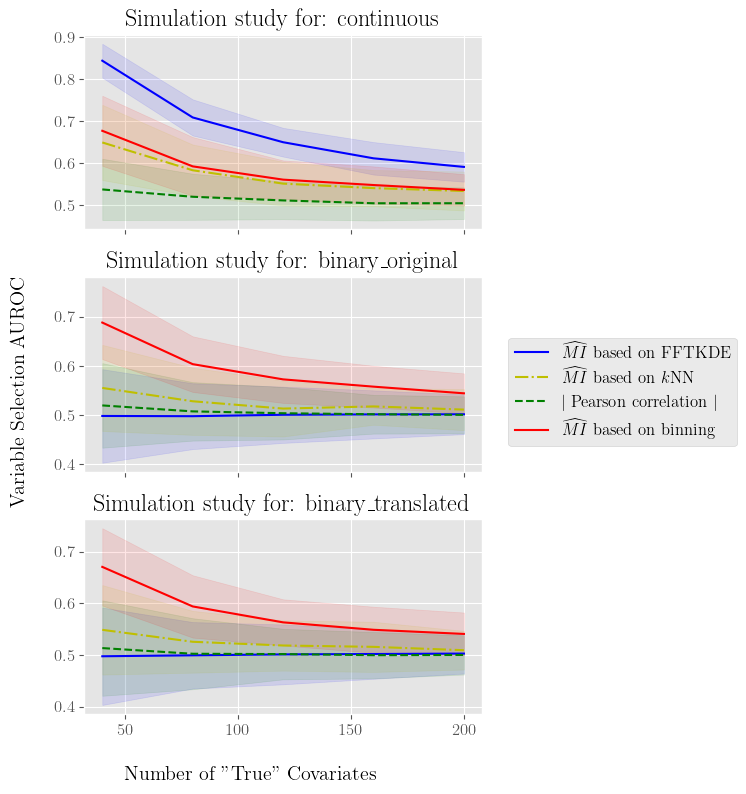

In [4]:
plot_mean = np.zeros((len(num_true_vars_list), 4))
plot_se = np.zeros((len(num_true_vars_list), 4))

fig, ax = plt.subplots(3, 1, figsize=(5, 8), sharex=True)

k = 0
for outcome in ["continuous", "binary_original", "binary_translated"]:
    j = 0
    for num_true_vars_iter in num_true_vars_list:
        try:
            computing_results = np.load(
                r"./ABIDE_simulations_nonlinear/ABIDE_{_outcome}_{_num_true_vars_iter}.npy"
                .format(_outcome=outcome,
                        _num_true_vars_iter=num_true_vars_iter))
            plot_mean[j, :] = np.mean(computing_results, axis=0)
            plot_se[j, :] = np.std(computing_results, axis=0)
        except:
            print(
                r"The data file, ./ABIDE_simulations_nonlinear/ABIDE_{_outcome}_{_num_true_vars_iter}.npy, doesn't exist"
                .format(_outcome=outcome,
                        _num_true_vars_iter=num_true_vars_iter))
            plot_mean[j, :] = np.nan
            plot_se[j, :] = np.nan
        j += 1

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 0],
        label=r"$\widehat{MI}$ based on FFTKDE",
        linestyle="-",
        color="b",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 0] + plot_se[:, 0] * norm.ppf(0.025)),
        (plot_mean[:, 0] + plot_se[:, 0] * norm.ppf(0.975)),
        color="b",
        alpha=0.1,
    )

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 1],
        label=r"$\widehat{MI}$ based on $k$NN",
        linestyle="-.",
        color="y",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 1] + plot_se[:, 1] * norm.ppf(0.025)),
        (plot_mean[:, 1] + plot_se[:, 1] * norm.ppf(0.975)),
        color="y",
        alpha=0.1,
    )

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 2],
        label=r"$\vert$ Pearson correlation $\vert$",
        linestyle="--",
        color="g",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 2] + plot_se[:, 2] * norm.ppf(0.025)),
        (plot_mean[:, 2] + plot_se[:, 2] * norm.ppf(0.975)),
        color="g",
        alpha=0.1,
    )

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 3],
        label=r"$\widehat{MI}$ based on binning",
        linestyle="-",
        color="r",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 3] + plot_se[:, 3] * norm.ppf(0.025)),
        (plot_mean[:, 3] + plot_se[:, 3] * norm.ppf(0.975)),
        color="r",
        alpha=0.1,
    )

    ax[k].set_title(r"Simulation study for: " + outcome)
    ax[k].label_outer()
    k += 1

# Adjust the right margin to make room for the legend
fig.subplots_adjust(right=0.85)

# Set centralized labels and legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
fig.supxlabel(r'Number of "True" Covariates')
fig.supylabel(r"Variable Selection AUROC")

# Save the plot
plt.tight_layout()
plt.savefig(
    r"./ABIDE_simulations_nonlinear/sim_nonlinear_combined.pdf",
    format="pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.show()

### For simulated linear outcomes

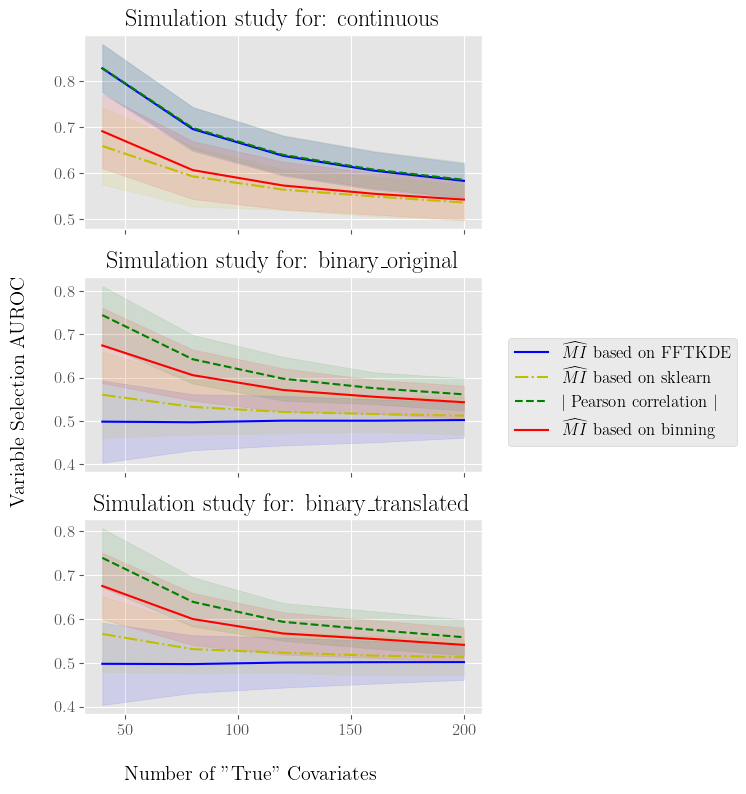

In [5]:
plot_mean = np.zeros((len(num_true_vars_list), 4))
plot_se = np.zeros((len(num_true_vars_list), 4))

fig, ax = plt.subplots(3, 1, figsize=(5, 8), sharex=True)

k = 0
for outcome in ["continuous", "binary_original", "binary_translated"]:
    j = 0
    for num_true_vars_iter in num_true_vars_list:
        try:
            computing_results = np.load(
                r"./ABIDE_simulations_linear/ABIDE_{_outcome}_{_num_true_vars_iter}.npy"
                .format(_outcome=outcome,
                        _num_true_vars_iter=num_true_vars_iter))
            plot_mean[j, :] = np.mean(computing_results, axis=0)
            plot_se[j, :] = np.std(computing_results, axis=0)
        except:
            print(
                r"The data file, ./ABIDE_simulations_linear/ABIDE_{_outcome}_{_num_true_vars_iter}.npy, doesn't exist"
                .format(_outcome=outcome,
                        _num_true_vars_iter=num_true_vars_iter))
            plot_mean[j, :] = np.nan
            plot_se[j, :] = np.nan
        j += 1

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 0],
        label=r"$\widehat{MI}$ based on FFTKDE",
        linestyle="-",
        color="b",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 0] + plot_se[:, 0] * norm.ppf(0.025)),
        (plot_mean[:, 0] + plot_se[:, 0] * norm.ppf(0.975)),
        color="b",
        alpha=0.1,
    )

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 1],
        label=r"$\widehat{MI}$ based on sklearn",
        linestyle="-.",
        color="y",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 1] + plot_se[:, 1] * norm.ppf(0.025)),
        (plot_mean[:, 1] + plot_se[:, 1] * norm.ppf(0.975)),
        color="y",
        alpha=0.1,
    )

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 2],
        label=r"$\vert$ Pearson correlation $\vert$",
        linestyle="--",
        color="g",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 2] + plot_se[:, 2] * norm.ppf(0.025)),
        (plot_mean[:, 2] + plot_se[:, 2] * norm.ppf(0.975)),
        color="g",
        alpha=0.1,
    )

    ax[k].plot(
        num_true_vars_list,
        plot_mean[:, 3],
        label=r"$\widehat{MI}$ based on binning",
        linestyle="-",
        color="r",
    )
    ax[k].fill_between(
        num_true_vars_list,
        (plot_mean[:, 3] + plot_se[:, 3] * norm.ppf(0.025)),
        (plot_mean[:, 3] + plot_se[:, 3] * norm.ppf(0.975)),
        color="r",
        alpha=0.1,
    )

    ax[k].set_title(r"Simulation study for: " + outcome)
    ax[k].label_outer()
    k += 1

# Adjust the right margin to make room for the legend
fig.subplots_adjust(right=0.85)

# Set centralized labels and legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
fig.supxlabel(r'Number of "True" Covariates')
fig.supylabel(r"Variable Selection AUROC")

# Save the plot
plt.tight_layout()
plt.savefig(
    r"./ABIDE_simulations_linear/sim_linear_combined.pdf",
    format="pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.show()

# Calculate MI for ABIDE data age and diagnosis outcome
## creating job submission scripts

In [6]:
from pathlib import Path


def engine_and_share_memory_status(mem_setting):
    if mem_setting == "high_mem":
        return "c", False
    elif mem_setting == "share_mem":
        return "c", True
    elif mem_setting == "dask":
        return "dask", False


def job_generator(mem_setting, outcome):
    py_1 = r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

"""
    if outcome == "age":
        py_2 = r"""
csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv"
abide = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
# abide = dd.read_csv(csv_file, sample=1250000)

_abide_name = abide.columns.tolist()[1:]
# _abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude covariates for adjustment in the screening since we choose to always include them in the model

abide_name = [_abide_name[-3]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

np.save(r"./ABIDE_columns", _abide_name[1:-3])

del _abide_name

print("The outcome is age.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}."
)
print("Our developed FFT-based MI calculation:")

for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        try:
            mi_output = mi.continuous_screening_csv_parallel(
                csv_file,
                _usecols=abide_name.copy(),
                csv_engine="{_csv_engine}",
                sample=1250000,
                multp=10,
                core_num=16,
                share_memory={_share_mem_status},
                kernel=_kernel,
                bw=_bw,
                norm=2)
            if "{mem_setting}" == "high_mem":
                np.save(
                    r"./ABIDE_age_MI_{{kernel}}_{{bw}}_output".format(
                        kernel=_kernel, bw=_bw), mi_output)

            del mi_output

        except:
            print("This kernel-bw combination reports an error: ", _kernel,
                  _bw)

print("binning MI calculation:")

binning_output = mi.binning_continuous_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=16,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_binningMI_output", binning_output)

print("sklearn MI calculation:")

skmi_output = mi.continuous_skMI_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=16,
    random_state=0,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_skMI_output", skmi_output)

del skmi_output

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=16,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_Pearson_output", pearson_output)

del pearson_output
""".format(
            _csv_engine=engine_and_share_memory_status(mem_setting)[0],
            _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
            mem_setting=mem_setting,
        )
    elif outcome == "diagnosis":
        py_2 = r"""
csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
abide = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
# abide = dd.read_csv(csv_file, sample=1250000)

_abide_name = abide.columns.tolist()[1:]
# _abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude covariates for adjustment in the screening since we choose to always include them in the model

abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

del _abide_name

print("The outcome is diagnosis.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}."
)
print("Our developed FFT-based MI calculation:")

for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        try:
            mi_output = mi.binary_screening_csv_parallel(
                csv_file,
                _usecols=abide_name.copy(),
                csv_engine="{_csv_engine}",
                sample=1250000,
                multp=10,
                core_num=16,
                share_memory={_share_mem_status},
                kernel=_kernel,
                bw=_bw)
            if "{mem_setting}" == "high_mem":
                np.save(
                    r"./ABIDE_diagnosis_MI_{{kernel}}_{{bw}}_output".format(
                        kernel=_kernel, bw=_bw), mi_output)

            del mi_output

        except:
            print("This kernel-bw combination reports an error: ", _kernel,
                  _bw)

print("binning MI calculation:")

binning_output = mi.binning_binary_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=16,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_binningMI_output", binning_output)

print("sklearn MI calculation:")

skmi_output = mi.binary_skMI_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=16,
    random_state=0,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_skMI_output", skmi_output)

del skmi_output

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=16,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_Pearson_output", pearson_output)

del pearson_output
""".format(
            _csv_engine=engine_and_share_memory_status(mem_setting)[0],
            _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
            mem_setting=mem_setting,
        )

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py").touch()
    py_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py", "w")
    py_script.write(py_1 + py_2)

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh").touch()
    bash_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=20:00:00
#SBATCH --job-name=ABIDE_screening_{outcome}_{mem_setting}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_screening_{outcome}_{mem_setting}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/

python3 ABIDE_screening_{outcome}_{mem_setting}.py
""".format(outcome=outcome, mem_setting=mem_setting))


for mem_setting in ["high_mem", "share_mem", "dask"]:
    for outcome in ["age", "diagnosis"]:
        job_generator(mem_setting=mem_setting, outcome=outcome)

# Running Speed Comparison for MI Estimation 

In [7]:
from pathlib import Path


def engine_and_share_memory_status(mem_setting):
    if mem_setting == "high_mem":
        return "c", False
    elif mem_setting == "share_mem":
        return "c", True
    elif mem_setting == "dask":
        return "dask", False


def job_generator(mem_setting, outcome):
    py_1 = r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os
import timeit

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
abide = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
# abide = dd.read_csv(csv_file, sample=1250000)

_abide_name = abide.columns.tolist()[1:]
# _abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since we choose to always include them in the model
"""
    if outcome == "age":
        py_2 = r"""
# age
abide_name = [_abide_name[-3]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas
del _abide_name

num_input_vars_divide = 10
prop_input_vars_list = np.linspace(0, 1, num_input_vars_divide)[1:]


def _get_computing_time(prop_input_vars):
    s = '''mi.continuous_screening_csv_parallel(csv_file, _usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)], csv_engine="{_csv_engine}", sample=1250000, multp=10, core_num=16, share_memory={_share_mem_status}, kernel="epa", bw="ISJ", norm=2,verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    FFTKDE_MI_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    s = '''mi.binning_continuous_screening_csv_parallel(csv_file, _usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)], csv_engine="{_csv_engine}", sample=1250000, multp=10, core_num=16, share_memory={_share_mem_status},verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    binning_MI_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    s = '''mi.continuous_skMI_screening_csv_parallel(csv_file, _usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)], csv_engine="{_csv_engine}", sample=1250000, multp=10, core_num=16, random_state=0, share_memory={_share_mem_status},verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    sklearn_MI_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    s = '''pearson_output = mi.Pearson_screening_csv_parallel(csv_file, _usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)], csv_engine="{_csv_engine}", sample=1250000, multp=10, core_num=16, share_memory={_share_mem_status},verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    Pearson_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    return np.vstack((FFTKDE_MI_times, sklearn_MI_times, Pearson_times, binning_MI_times))


print(
    "Running speed comparison when the outcome variable is age (continuous) and the memory setting is {mem_setting}... "
)
output_array = np.array(
    list(map(_get_computing_time, tqdm(prop_input_vars_list))))
np.save(r"./running_time_age_{mem_setting}", output_array)
""".format(
            _csv_engine=engine_and_share_memory_status(mem_setting)[0],
            _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
            mem_setting=mem_setting,
        )
    elif outcome == "diagnosis":
        py_2 = r"""
# diagnosis
abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas
del _abide_name

num_input_vars_divide = 10
prop_input_vars_list = np.linspace(0, 1, num_input_vars_divide)[1:]


def _get_computing_time(prop_input_vars):
    s = '''mi.binary_screening_csv_parallel(csv_file,_usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)],csv_engine="{_csv_engine}",sample=1250000,multp=10,core_num=16,share_memory={_share_mem_status},kernel="epa",bw="ISJ",verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    FFTKDE_MI_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    s = '''mi.binning_binary_screening_csv_parallel(csv_file, _usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)], csv_engine="{_csv_engine}", sample=1250000, multp=10, core_num=16, share_memory={_share_mem_status},verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    binning_MI_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    s = '''mi.binary_skMI_screening_csv_parallel(csv_file,_usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)],csv_engine="{_csv_engine}",sample=1250000,multp=10,core_num=16,random_state=0,share_memory={_share_mem_status},verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    sklearn_MI_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    s = '''pearson_output = mi.Pearson_screening_csv_parallel( csv_file, _usecols=abide_name.copy()[0:int(len(abide_name)*prop_input_vars)], csv_engine="{_csv_engine}", sample=1250000, multp=10, core_num=16, share_memory={_share_mem_status},verbose=0)'''
    imports_and_vars = globals()
    imports_and_vars.update(locals())
    num_loops = timeit.Timer(stmt=s, globals=imports_and_vars).autorange()[0]
    Pearson_times = timeit.Timer(stmt=s, globals=imports_and_vars).repeat(
        repeat=5, number=num_loops)

    return np.vstack((FFTKDE_MI_times, sklearn_MI_times, Pearson_times, binning_MI_times))


print(
    "Running speed comparison when the outcome variable is diagnosis (binary) and the memory setting is {mem_setting}... "
)
output_array = np.array(
    list(map(_get_computing_time, tqdm(prop_input_vars_list))))
np.save(r"./running_time_diagnosis_{mem_setting}", output_array)
""".format(
            _csv_engine=engine_and_share_memory_status(mem_setting)[0],
            _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
            mem_setting=mem_setting,
        )

    Path(r"./running_speed/speed_comparison_" + outcome + "_" + mem_setting +
         ".py").touch()
    py_script = open(
        r"./running_speed/speed_comparison_" + outcome + "_" + mem_setting +
        ".py", "w")
    py_script.write(py_1 + py_2)

    Path(r"./running_speed/speed_comparison_" + outcome + "_" + mem_setting +
         ".sh").touch()
    bash_script = open(
        r"./running_speed/speed_comparison_" + outcome + "_" + mem_setting +
        ".sh", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=6-12:00:00
#SBATCH --job-name=ABIDE_screening_{outcome}_{mem_setting}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_screening_{outcome}_{mem_setting}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/

python3 speed_comparison_{outcome}_{mem_setting}.py
""".format(outcome=outcome, mem_setting=mem_setting))


for mem_setting in ["high_mem", "share_mem"]:
    for outcome in ["age", "diagnosis"]:
        job_generator(mem_setting=mem_setting, outcome=outcome)

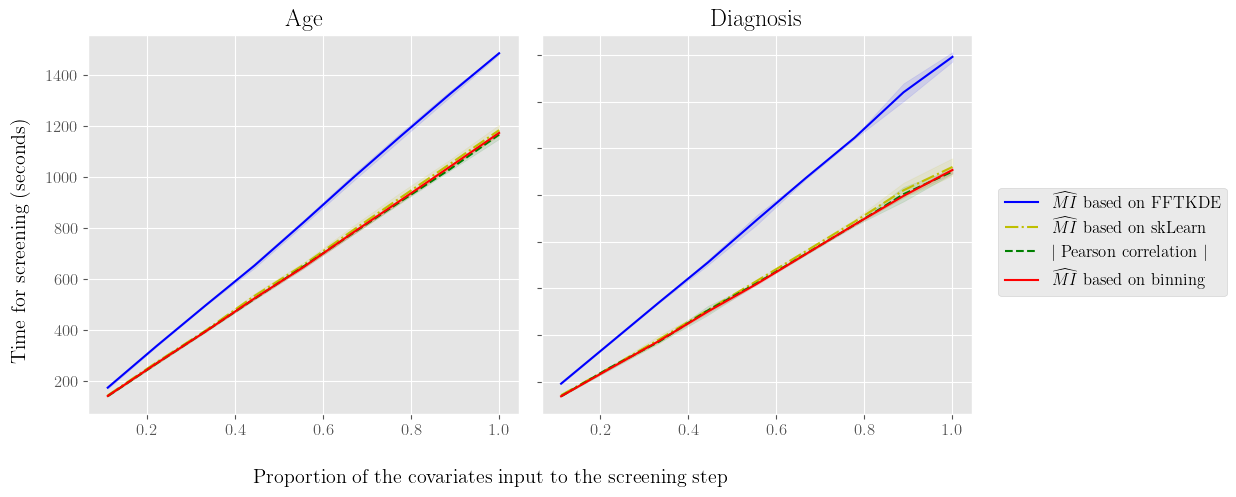

In [8]:
num_true_vars_list = np.linspace(0, 1, 10)[1:]

# Adjusted to only include the necessary files
file_names = [
    "running_time_age_share_mem.npy",
    "running_time_diagnosis_share_mem.npy",
]

# Adjust the figure size and subplot configuration for two plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax = ax.flatten()

# Simplified loop for only the specified files
for k, file_name in enumerate(file_names):
    try:
        computing_results = np.load(f"./running_speed/{file_name}")
        plot_mean = np.mean(computing_results, axis=2)
        plot_se = np.std(computing_results, axis=2)
    except FileNotFoundError:
        print(f"The data file, ./running_speed/{file_name}, doesn't exist")
        continue  # Skip this iteration

    # Plot configurations for each method
    for method_index, (label, linestyle, color) in enumerate([
        (r"$\widehat{MI}$ based on FFTKDE", "-", "b"),
        (r"$\widehat{MI}$ based on skLearn", "-.", "y"),
        (r"$\vert$ Pearson correlation $\vert$", "--", "g"),
        (r"$\widehat{MI}$ based on binning", "-", "r"),
    ]):
        ax[k].plot(
            num_true_vars_list,
            plot_mean[:, method_index],
            label=label,
            linestyle=linestyle,
            color=color,
        )
        ax[k].fill_between(
            num_true_vars_list,
            (plot_mean[:, method_index] +
             plot_se[:, method_index] * norm.ppf(0.025)),
            (plot_mean[:, method_index] +
             plot_se[:, method_index] * norm.ppf(0.975)),
            color=color,
            alpha=0.1,
        )

    # Setting titles for each subplot based on the file names
    if "age" in file_name:
        ax[k].set_title("Age")
    else:
        ax[k].set_title("Diagnosis")

    ax[k].label_outer()

# Legend and labels
fig.legend(*ax[0].get_legend_handles_labels(),
           loc="center left",
           bbox_to_anchor=(1, 0.5))
fig.supxlabel(r"Proportion of the covariates input to the screening step")
fig.supylabel(r"Time for screening (seconds)")

plt.tight_layout()
plt.savefig("./running_speed/running_speed_combined.pdf",
            format="pdf",
            dpi=600,
            bbox_inches="tight")
plt.show()

# Plots for age
## Comparing two ranking with Kendall's $\tau$

**So in summary, the two ranking vary somehow.**

In [9]:
# abide_mi = np.load(r"./ABIDE_age_MI_output.npy")
# plt.hist(np.log(abide_mi), 500)
# plt.show()

# abide_pearson = np.load(r"./ABIDE_age_Pearson_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# abide_skmi = np.load(r"./ABIDE_age_skMI_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# print("Kendall'stau for MI vs Pearson: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# plt.scatter(np.log(abide_mi), abide_pearson, s=10,
#             alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT AGE

# print("Kendall'stau for MI vs skMI: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_skmi))))

# plt.scatter(np.log(abide_mi), abide_skmi, s=10, alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT AGE

# Plots for diagnosis
## Comparing two ranking with Kendall's $\tau$

In [10]:
# abide_mi = np.load(r"./ABIDE_diagnosis_MI_output.npy")
# plt.hist(np.log(abide_mi), 500)
# plt.show()

# abide_pearson = np.load(r"./ABIDE_diagnosis_Pearson_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# abide_skmi = np.load(r"./ABIDE_diagnosis_skMI_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# print("Kendall'stau for MI vs Pearson: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# plt.scatter(np.log(abide_mi), abide_pearson, s=10,
#             alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT diagnosis

# print("Kendall'stau for MI vs skMI: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_skmi))))

# plt.scatter(np.log(abide_mi), abide_skmi, s=10, alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT diagnosis

# A scatter plot for age and diagnosis

In [11]:
from pathlib import Path


def job_creator():
    Path(r"./ABIDE_scatterplot/scatter_plot_for_most_associated.sh").touch()
    Path(r"./ABIDE_scatterplot/scatter_plot_for_most_associated.py").touch()
    bash_script = open(
        r"./ABIDE_scatterplot/scatter_plot_for_most_associated.sh", "w")
    py_script = open(
        r"./ABIDE_scatterplot/scatter_plot_for_most_associated.py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=2:00:00
#SBATCH --job-name=scatter_plot_for_most_associated

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running scatter_plot_for_most_associated.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_MI_epa_ISJ_output.npy $SLURM_TMPDIR/
cp ../ABIDE_age_Pearson_output.npy $SLURM_TMPDIR/
cp ../ABIDE_age_skMI_output.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_MI_epa_ISJ_output.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_Pearson_output.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_skMI_output.npy $SLURM_TMPDIR/

python3 scatter_plot_for_most_associated.py
    """)
    py_script.write(r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

top_colnames_num = 5

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")

for outcome in ["diagnosis", "age"]:
    top_colnames = []
    for dep_measure in ["MI_epa_ISJ", "Pearson", "skMI"]:
        abide_dep = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_" + outcome +
                            r"_" + dep_measure + r"_output.npy")
        abide_dep = np.absolute(abide_dep)

        top_colnames = np.hstack(
            (top_colnames, columns[np.argsort(-abide_dep)][:top_colnames_num]))

    top_colnames = list(set(top_colnames))
    for colname in top_colnames:
        if outcome == "diagnosis":
            plt.scatter(original_df["DX_GROUP"],
                        original_df[colname],
                        alpha=.2)
        if outcome == "age":
            plt.scatter(original_df["AGE_AT_SCAN"],
                        original_df[colname],
                        alpha=.2)
        plt.ylabel(outcome)
        plt.xlabel(colname)
        plt.title(r"scatter plot for outcome vs the top associated covariates: " + outcome +
                  r" and " + colname)
        plt.savefig(r"scatter_" + outcome + r"_" + colname + ".pdf", format="pdf", dpi=600)
        plt.close()
    """)


job_creator()

# Try Fitting models to predict age, $5$-fold CV for hyper-parameter tuning
## create job submission scripts for `ABIDE_predict_age` 

In [12]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".sh").touch()
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".sh", "w")
    py_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=age_{dep_measure}_{fun_name}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_age_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(os.environ["SLURM_TMPDIR"] +
                    r"/ABIDE_age_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name, "SEX", #"DX_GROUP", # comment out DX_GROUP as we are using cases only
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=20)
np.save(r"./ABIDE_age_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LassoCV",
        "ElasticNetCV",
        "RidgeCV",
        "LarsCV",
        "LassoLarsCV",
        "MLPRegressor",
        "RandomForestRegressor",
        "LinearRegression",
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI", "binningMI"]:
        job_creator(dep_measure, fun_name)

## create job submission scripts for `ABIDE_poly3_predict_age`

In [13]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
         fun_name + ".sh").touch()
    Path(r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
         fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
        fun_name + ".sh",
        "w",
    )
    py_script = open(
        r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
        fun_name + ".py",
        "w",
    )
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=poly3_age_{dep_measure}_{fun_name}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_poly3_age_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_poly3_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(os.environ["SLURM_TMPDIR"] +
                    r"/ABIDE_age_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name, "SEX", #"DX_GROUP", # comment out DX_GROUP as we are using cases only
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X = SplineTransformer(n_knots=2,
                              degree=3,
                              extrapolation="continue",
                              include_bias=False).fit_transform(X)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_poly3_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=20)
np.save(r"./ABIDE_poly3_age_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LassoCV",
        "ElasticNetCV",
        "RidgeCV",
        "LarsCV",
        "LassoLarsCV",
        "MLPRegressor",
        "RandomForestRegressor",
        "LinearRegression",
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI", "binningMI"]:
        job_creator(dep_measure, fun_name)

# Comparison of Performance
## Here is just to show the testing set $R^2$ using plots
### using variables directly

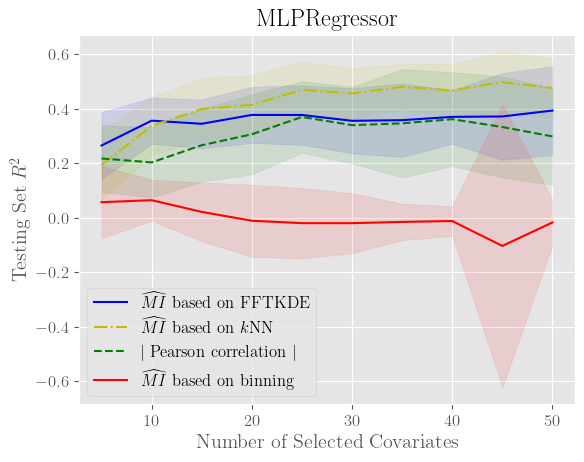

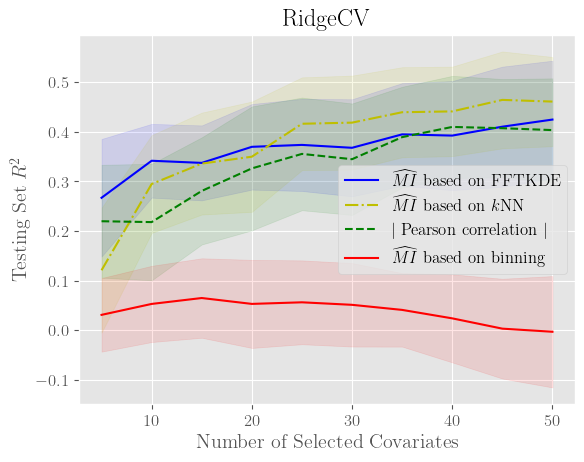

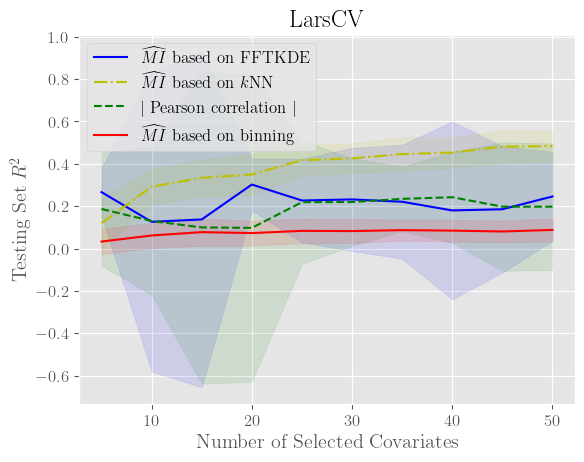

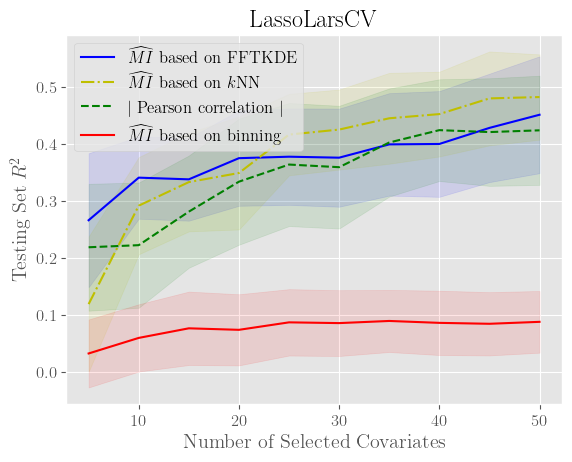

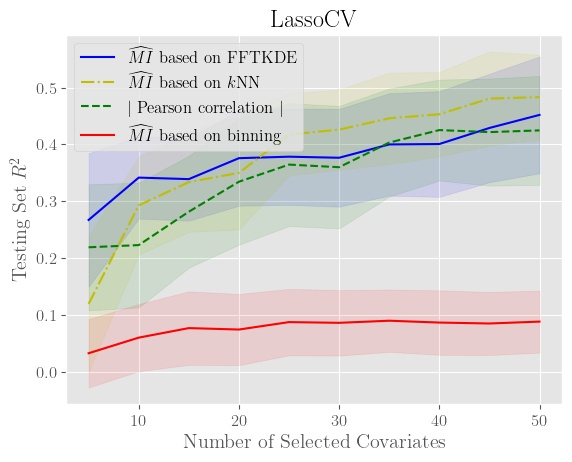

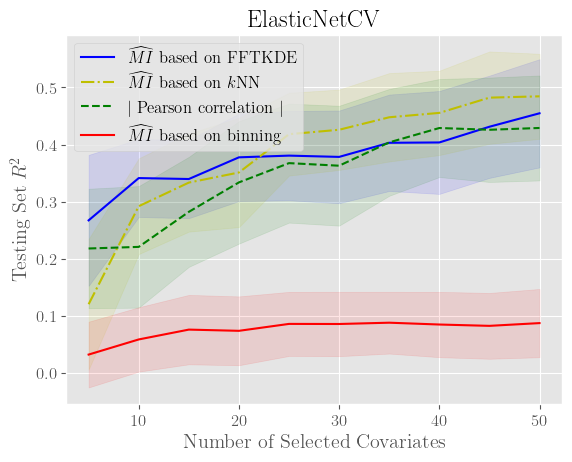

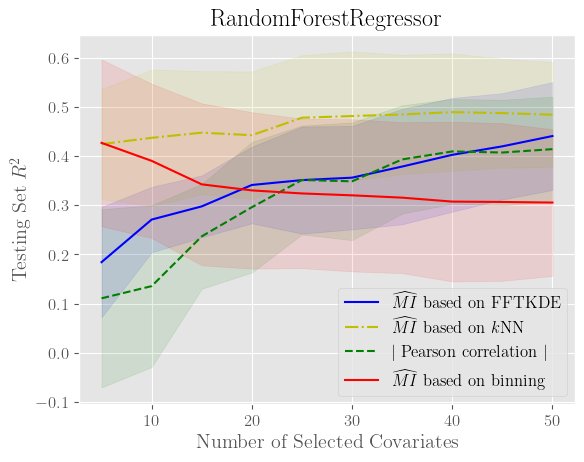

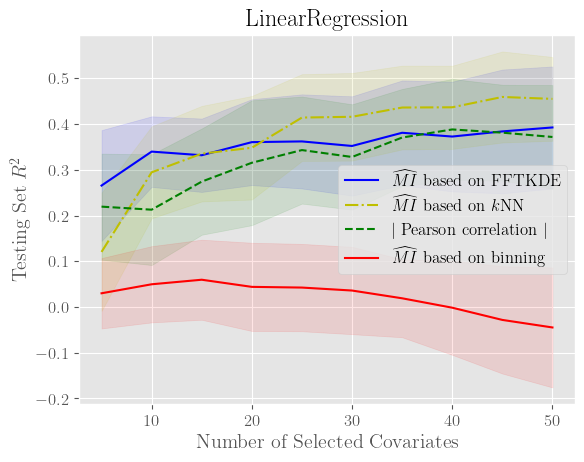

In [14]:
def plot_results(_plt, fun_name, dep_measure):
    if (os.path.isfile(
            r"./ABIDE_predict_age/ABIDE_age_{dep_measure}_{fun_name}.npy".
            format(fun_name=fun_name, dep_measure=dep_measure))
            and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                    fun_name=fun_name))
            and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_binningMI_{fun_name}.npy".
                format(fun_name=fun_name))
            and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                    fun_name=fun_name))):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_{dep_measure}_{fun_name}.npy".
            format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_binningMI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_binningMI_{fun_name}.npy".format(
                fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)
        binningMI_fit_mean = np.mean(ABIDE_age_binningMI_foo, 1)
        binningMI_fit_std = np.std(ABIDE_age_binningMI_foo, 1)

        _plt.plot(num_attr,
                  MI_fit_mean,
                  label=r"$\widehat{MI}$ based on FFTKDE",
                  linestyle="-",
                  color="b")
        _plt.fill_between(
            num_attr,
            (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
            (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
            color="b",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            skMI_fit_mean,
            label=r"$\widehat{MI}$ based on $k$NN",
            linestyle="-.",
            color="y",
        )
        _plt.fill_between(
            num_attr,
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
            color="y",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            Pearson_fit_mean,
            label=r"$\vert$ Pearson correlation $\vert$",
            linestyle="--",
            color="g",
        )
        _plt.fill_between(
            num_attr,
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            binningMI_fit_mean,
            label=r"$\widehat{MI}$ based on binning",
            linestyle="-",
            color="r",
        )
        _plt.fill_between(
            num_attr,
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.025)),
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.975)),
            color="r",
            alpha=0.1,
        )

        _plt.title(fun_name)
        _plt.legend()
        plt.ylabel(r"Testing Set $R^2$")
        plt.xlabel(r"Number of Selected Covariates")


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPRegressor",
            "RidgeCV",
            "LarsCV",
            "LassoLarsCV",
            "LassoCV",
            "ElasticNetCV",
            "RandomForestRegressor",
            "LinearRegression",
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(
                r"./ABIDE_predict_age/age_" + fun_name + "_" + dep_measure +
                ".pdf",
                format="pdf",
                dpi=600,
            )
            plt.show()

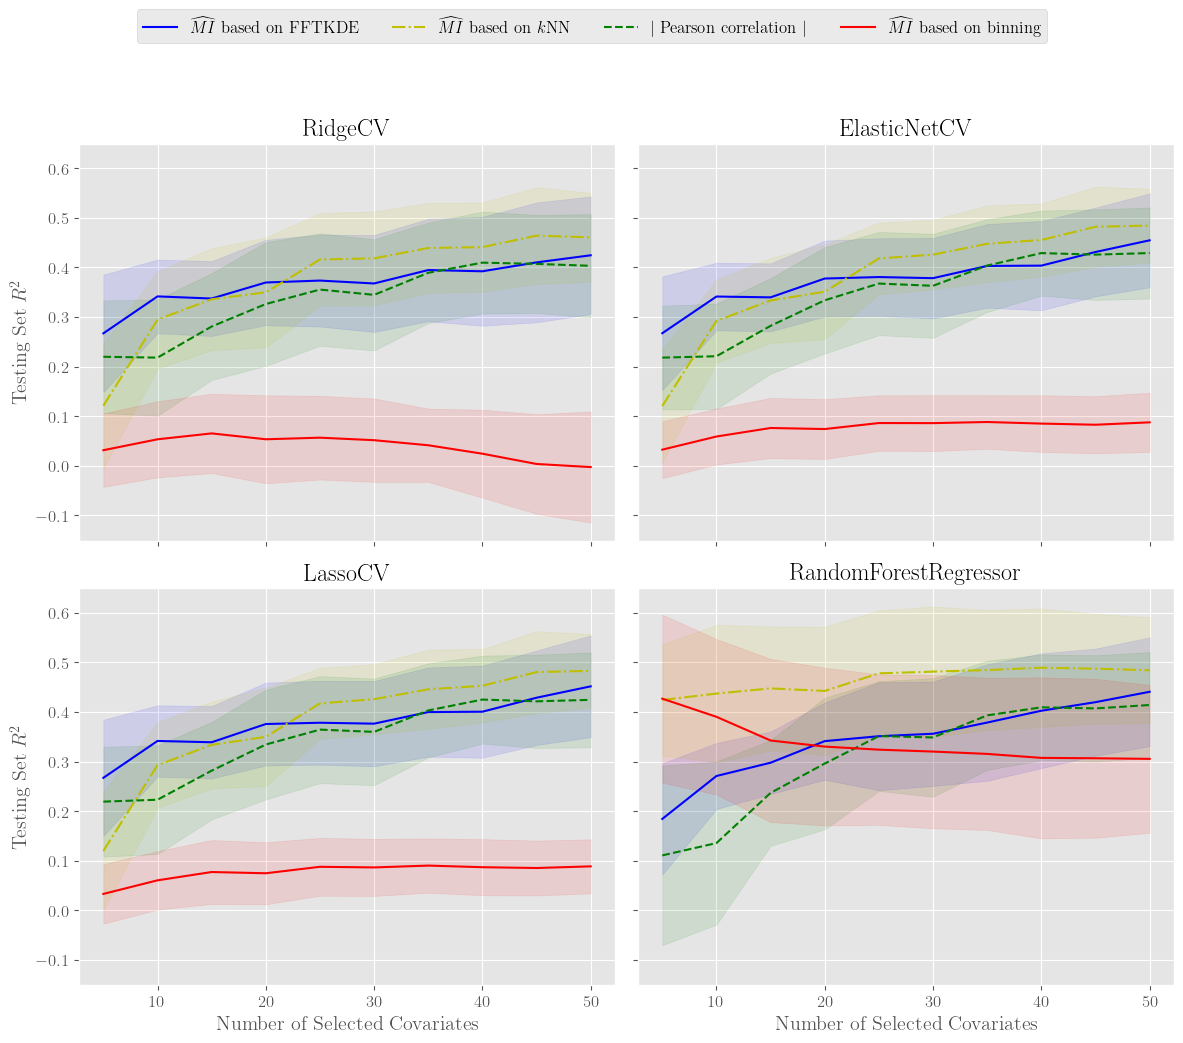

In [15]:
def plot_results(ax, fun_name, dep_measure):
    if (os.path.isfile(
            r"./ABIDE_predict_age/ABIDE_age_{dep_measure}_{fun_name}.npy".
            format(fun_name=fun_name, dep_measure=dep_measure))
            and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                    fun_name=fun_name))
            and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_binningMI_{fun_name}.npy".
                format(fun_name=fun_name))
            and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                    fun_name=fun_name))):

        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_{dep_measure}_{fun_name}.npy".
            format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_binningMI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_binningMI_{fun_name}.npy".format(
                fun_name=fun_name))

        num_attr = list(
            map(int,
                np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist()))

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)
        binningMI_fit_mean = np.mean(ABIDE_age_binningMI_foo, 1)
        binningMI_fit_std = np.std(ABIDE_age_binningMI_foo, 1)

        ax.plot(num_attr,
                MI_fit_mean,
                label=r"$\widehat{MI}$ based on FFTKDE",
                linestyle="-",
                color="b")
        ax.fill_between(
            num_attr,
            (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
            (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
            color="b",
            alpha=0.1,
        )

        ax.plot(
            num_attr,
            skMI_fit_mean,
            label=r"$\widehat{MI}$ based on $k$NN",
            linestyle="-.",
            color="y",
        )
        ax.fill_between(
            num_attr,
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
            color="y",
            alpha=0.1,
        )

        ax.plot(
            num_attr,
            Pearson_fit_mean,
            label=r"$\vert$ Pearson correlation $\vert$",
            linestyle="--",
            color="g",
        )
        ax.fill_between(
            num_attr,
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=0.1,
        )

        ax.plot(
            num_attr,
            binningMI_fit_mean,
            label=r"$\widehat{MI}$ based on binning",
            linestyle="-",
            color="r",
        )
        ax.fill_between(
            num_attr,
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.025)),
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.975)),
            color="r",
            alpha=0.1,
        )

        ax.set_title(fun_name)


# Prepare subplots with shared x and y axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Define the functions and dependent measure
fun_names = ["RidgeCV", "ElasticNetCV", "LassoCV", "RandomForestRegressor"]
dep_measure = "MI_epa_ISJ"

# Plot the results in subplots
for i, fun_name in enumerate(fun_names):
    plot_results(axs[i], fun_name, dep_measure)

# Set common labels only on the outer subplots
axs[0].set_ylabel(r"Testing Set $R^2$")
axs[2].set_ylabel(r"Testing Set $R^2$")
axs[2].set_xlabel(r"Number of Selected Covariates")
axs[3].set_xlabel(r"Number of Selected Covariates")

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add the shared legend outside of the plot area
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper center',
           ncol=4,
           bbox_to_anchor=(0.5, 1.05))

# Save the figure with the legend included
plt.savefig(r"./ABIDE_predict_age/age_comparison_{}.pdf".format(dep_measure),
            format="pdf",
            dpi=600,
            bbox_inches="tight")
plt.show()

### using Bernstein polynomials of degree $3$

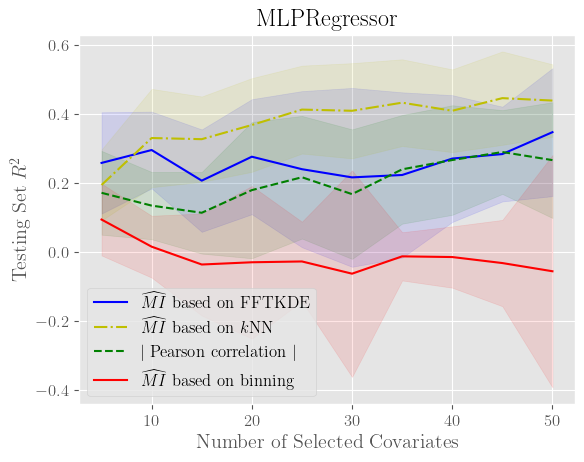

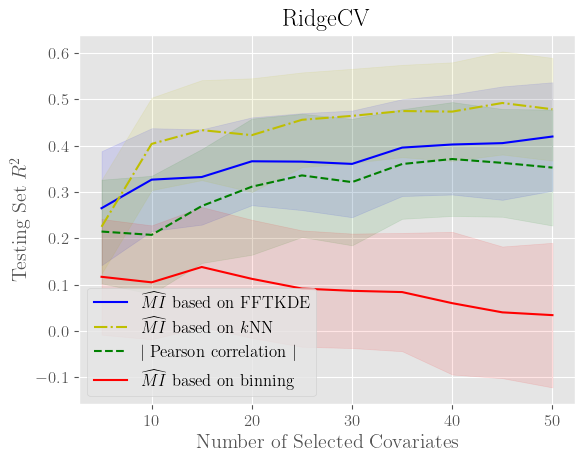

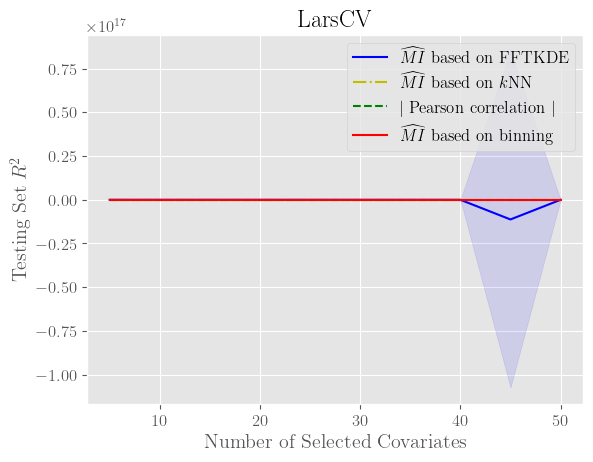

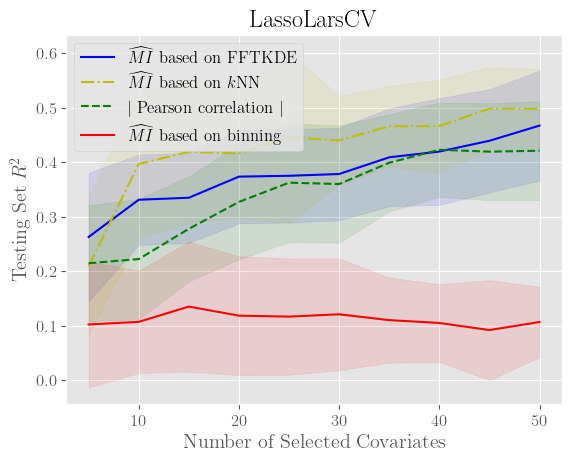

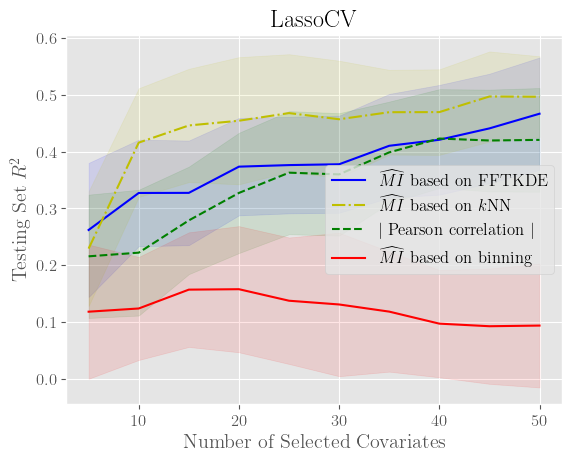

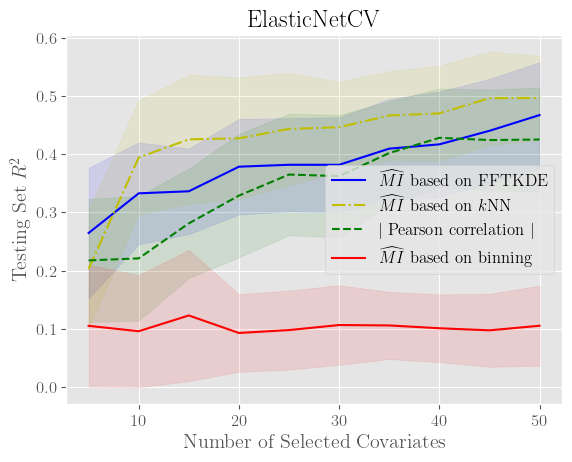

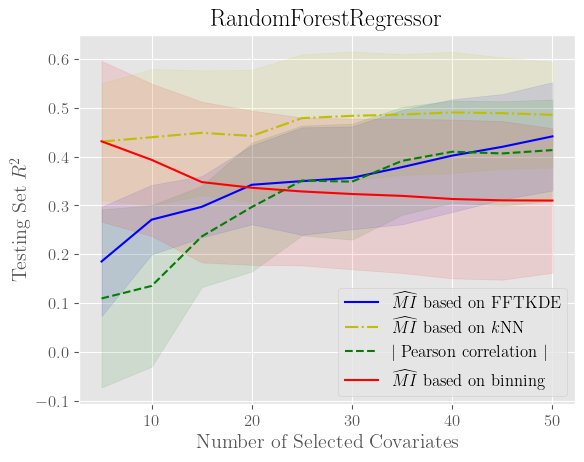

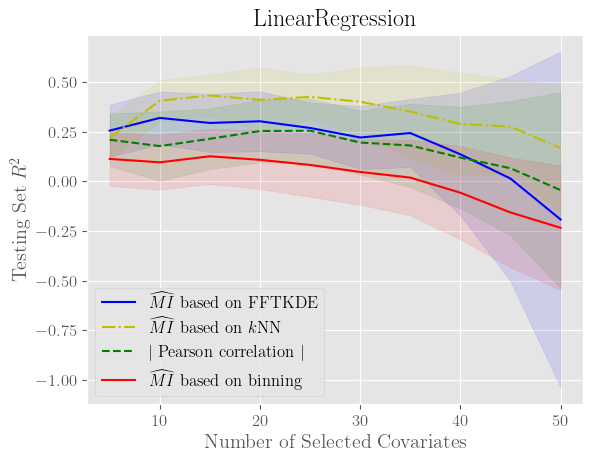

In [16]:
def plot_results(_plt, fun_name, dep_measure):
    if (os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_age_binningMI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)
        binningMI_fit_mean = np.mean(ABIDE_age_binningMI_foo, 1)
        binningMI_fit_std = np.std(ABIDE_age_binningMI_foo, 1)

        _plt.plot(num_attr,
                  MI_fit_mean,
                  label=r"$\widehat{MI}$ based on FFTKDE",
                  linestyle="-",
                  color="b")
        _plt.fill_between(
            num_attr,
            (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
            (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
            color="b",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            skMI_fit_mean,
            label=r"$\widehat{MI}$ based on $k$NN",
            linestyle="-.",
            color="y",
        )
        _plt.fill_between(
            num_attr,
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
            color="y",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            Pearson_fit_mean,
            label=r"$\vert$ Pearson correlation $\vert$",
            linestyle="--",
            color="g",
        )
        _plt.fill_between(
            num_attr,
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            binningMI_fit_mean,
            label=r"$\widehat{MI}$ based on binning",
            linestyle="-",
            color="r",
        )
        _plt.fill_between(
            num_attr,
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.025)),
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.975)),
            color="r",
            alpha=0.1,
        )

        _plt.title(fun_name)
        _plt.legend()
        plt.ylabel(r"Testing Set $R^2$")
        plt.xlabel(r"Number of Selected Covariates")


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPRegressor",
            "RidgeCV",
            "LarsCV",
            "LassoLarsCV",
            "LassoCV",
            "ElasticNetCV",
            "RandomForestRegressor",
            "LinearRegression",
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(
                r"./ABIDE_poly3_predict_age/poly3_age_" + fun_name + "_" +
                dep_measure + ".pdf",
                format="pdf",
                dpi=600,
            )
            plt.show()

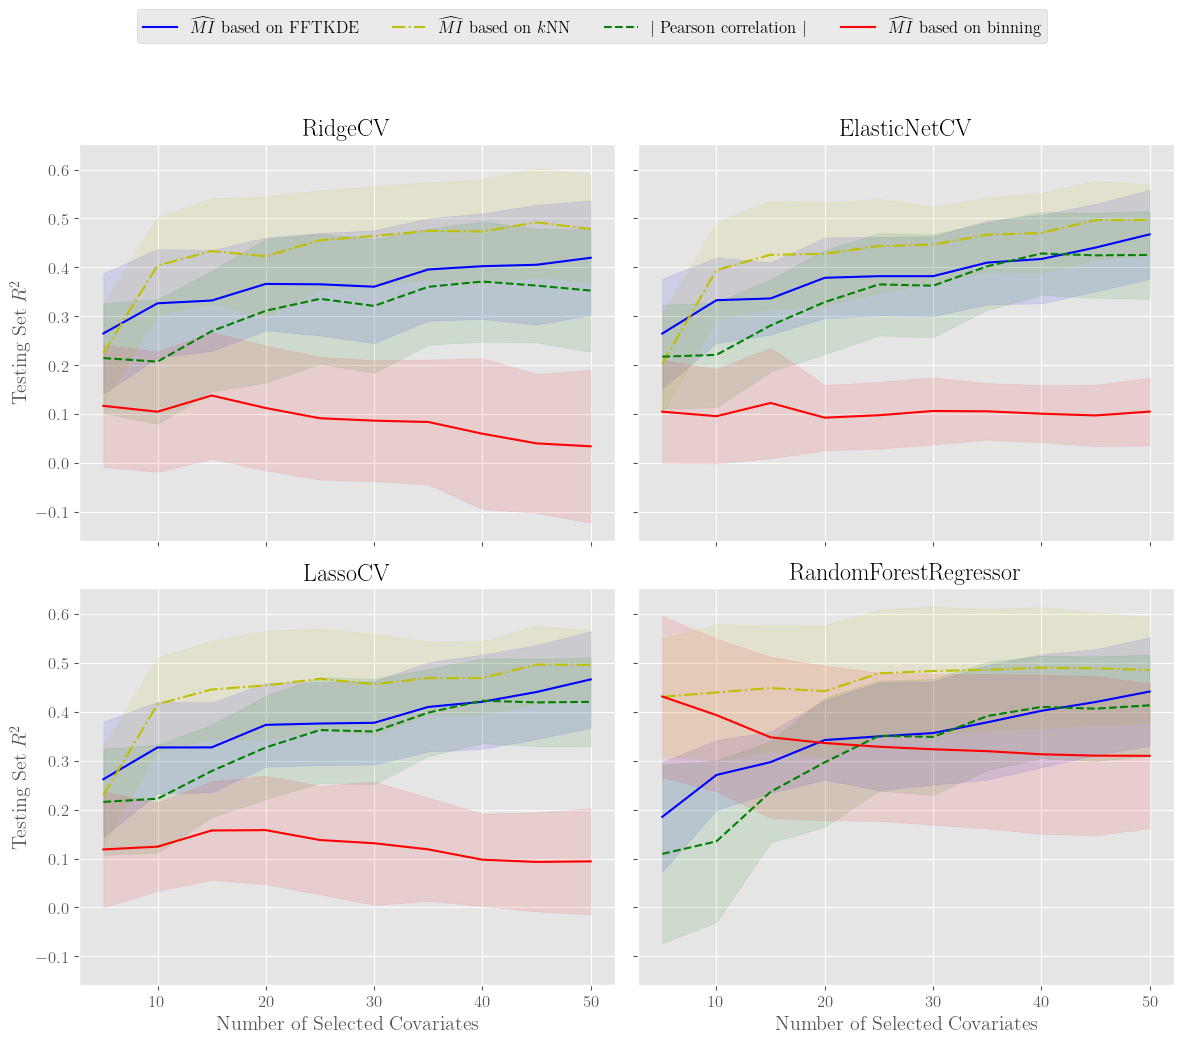

In [17]:
def plot_results(ax, fun_name, dep_measure):
    if (os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))):

        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_age_binningMI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name))

        num_attr = list(
            map(int,
                np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist()))

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)
        binningMI_fit_mean = np.mean(ABIDE_age_binningMI_foo, 1)
        binningMI_fit_std = np.std(ABIDE_age_binningMI_foo, 1)

        ax.plot(num_attr,
                MI_fit_mean,
                label=r"$\widehat{MI}$ based on FFTKDE",
                linestyle="-",
                color="b")
        ax.fill_between(
            num_attr,
            (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
            (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
            color="b",
            alpha=0.1,
        )

        ax.plot(
            num_attr,
            skMI_fit_mean,
            label=r"$\widehat{MI}$ based on $k$NN",
            linestyle="-.",
            color="y",
        )
        ax.fill_between(
            num_attr,
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
            color="y",
            alpha=0.1,
        )

        ax.plot(
            num_attr,
            Pearson_fit_mean,
            label=r"$\vert$ Pearson correlation $\vert$",
            linestyle="--",
            color="g",
        )
        ax.fill_between(
            num_attr,
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=0.1,
        )

        ax.plot(
            num_attr,
            binningMI_fit_mean,
            label=r"$\widehat{MI}$ based on binning",
            linestyle="-",
            color="r",
        )
        ax.fill_between(
            num_attr,
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.025)),
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.975)),
            color="r",
            alpha=0.1,
        )

        ax.set_title(fun_name)


# Prepare subplots with shared x and y axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Define the functions and dependent measure
fun_names = ["RidgeCV", "ElasticNetCV", "LassoCV", "RandomForestRegressor"]
dep_measure = "MI_epa_ISJ"

# Plot the results in subplots
for i, fun_name in enumerate(fun_names):
    plot_results(axs[i], fun_name, dep_measure)

# Set common labels only on the outer subplots
axs[0].set_ylabel(r"Testing Set $R^2$")
axs[2].set_ylabel(r"Testing Set $R^2$")
axs[2].set_xlabel(r"Number of Selected Covariates")
axs[3].set_xlabel(r"Number of Selected Covariates")

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add the shared legend outside of the plot area
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper center',
           ncol=4,
           bbox_to_anchor=(0.5, 1.05))

# Save the figure with the legend included
plt.savefig(r"./ABIDE_poly3_predict_age/poly3_age_comparison_{}.pdf".format(
    dep_measure),
    format="pdf",
    dpi=600,
    bbox_inches="tight")
plt.show()

# Try Fitting models to predict diagnosis, $5$-fold CV
## create job submission scripts for `ABIDE_predict_diagnosis`

In [18]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
         fun_name + ".sh").touch()
    Path(r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
         fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
        fun_name + ".sh",
        "w",
    )
    py_script = open(
        r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
        fun_name + ".py",
        "w",
    )
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=diagnosis_{dep_measure}_{fun_name}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_diagnosis_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_diagnosis_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(
    os.environ["SLURM_TMPDIR"] +
    r"/ABIDE_diagnosis_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name, "SEX", "AGE_AT_SCAN",
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="DX_GROUP",
    num_rep=20)
np.save(r"./ABIDE_diagnosis_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LogisticRegressionCV_l1",
        "LogisticRegressionCV_l2",
        "LogisticRegressionCV_ElasticNet",
        "MLPClassifier",
        "RandomForestClassifier",
        "LogisticRegression",
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI", "binningMI"]:
        job_creator(dep_measure, fun_name)

## create job submission scripts for `ABIDE_poly3_predict_diagnosis`

In [19]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
         dep_measure + "_" + fun_name + ".sh").touch()
    Path(r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
         dep_measure + "_" + fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
        dep_measure + "_" + fun_name + ".sh",
        "w",
    )
    py_script = open(
        r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
        dep_measure + "_" + fun_name + ".py",
        "w",
    )
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=poly3_diagnosis_{dep_measure}_{fun_name}

module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip Cython

# ### run this block at the login node to build wheels
# module load arch/avx2 gcc llvm rust arrow nodejs python/3.10 r/4.0.2 python-build-bundle/2023b
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.9
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.9 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built dask 2024.2.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package dask --version 2024.2.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.25.16
# pip install fastHDMI==1.25.16 --no-cache-dir
# pip wheel fastHDMI --no-deps

# # Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 pandas dask Cython
pip install --no-index /home/kyang/KDEpy-1.1.9+computecanada-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.25.16-cp310-cp310-linux_x86_64.whl
pip install --no-index /home/kyang/dask-2024.2.1+computecanada-py3-none-any.whl

nvidia-smi
lscpu

echo "running ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.py"

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/
cp /home/kyang/projects/def-cgreenwo/kyang/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX_CasesOnly.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
# from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
from scipy.linalg import block_diag, toeplitz
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(
    os.environ["SLURM_TMPDIR"] +
    r"/ABIDE_diagnosis_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name, "SEX", "AGE_AT_SCAN",
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X = SplineTransformer(n_knots=2,
                              degree=3,
                              extrapolation="continue",
                              include_bias=False).fit_transform(X)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=16, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=16,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=16).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_poly3_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="DX_GROUP",
    num_rep=20)
np.save(r"./ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LogisticRegressionCV_l1",
        "LogisticRegressionCV_l2",
        "LogisticRegressionCV_ElasticNet",
        "MLPClassifier",
        "RandomForestClassifier",
        "LogisticRegression",
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI", "binningMI"]:
        job_creator(dep_measure, fun_name)

# Comparison of Performance
## Here is just to show the testing set ROC
### using variables directly

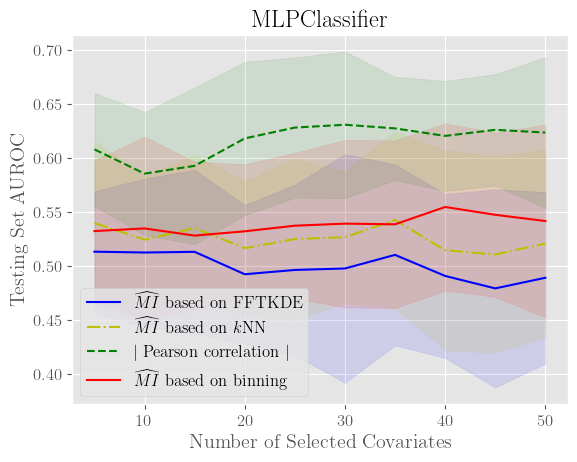

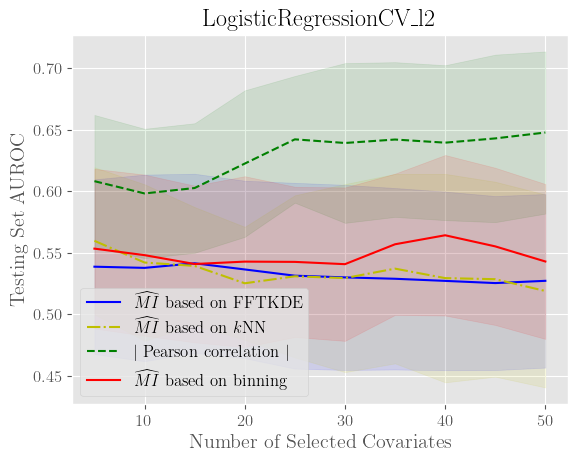

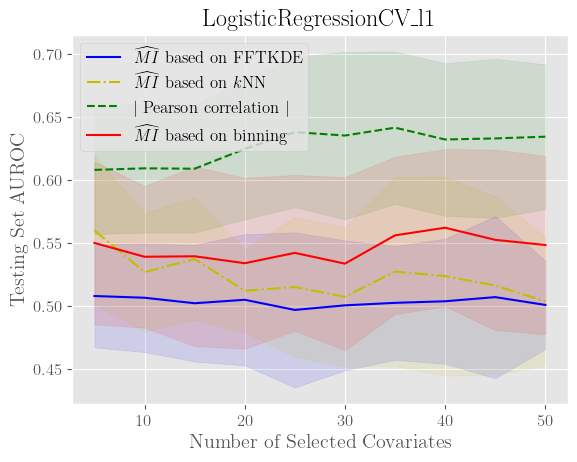

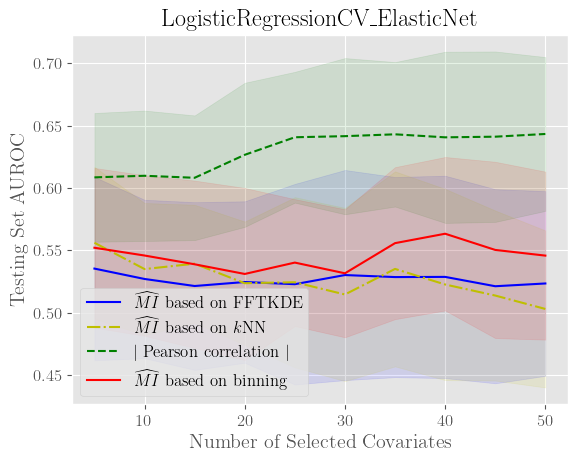

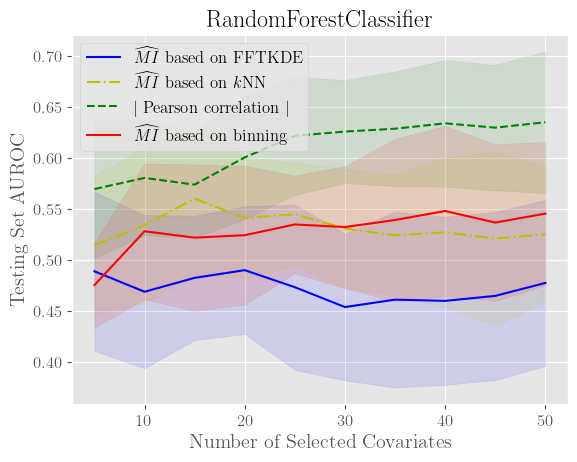

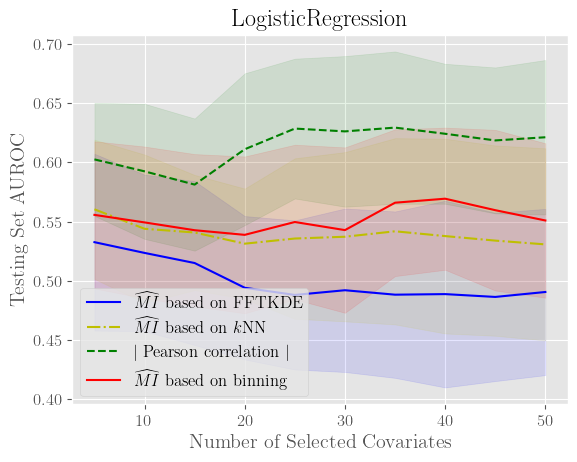

In [20]:
import os


def plot_results(_plt, fun_name, dep_measure):
    if (os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_binningMI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, 1)
        binningMI_fit_mean = np.mean(ABIDE_diagnosis_binningMI_foo, 1)
        binningMI_fit_std = np.std(ABIDE_diagnosis_binningMI_foo, 1)

        _plt.plot(num_attr,
                  MI_fit_mean,
                  label=r"$\widehat{MI}$ based on FFTKDE",
                  linestyle="-",
                  color="b")
        _plt.fill_between(
            num_attr,
            (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
            (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
            color="b",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            skMI_fit_mean,
            label=r"$\widehat{MI}$ based on $k$NN",
            linestyle="-.",
            color="y",
        )
        _plt.fill_between(
            num_attr,
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
            color="y",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            Pearson_fit_mean,
            label=r"$\vert$ Pearson correlation $\vert$",
            linestyle="--",
            color="g",
        )
        _plt.fill_between(
            num_attr,
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            binningMI_fit_mean,
            label=r"$\widehat{MI}$ based on binning",
            linestyle="-",
            color="r",
        )
        _plt.fill_between(
            num_attr,
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.025)),
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.975)),
            color="r",
            alpha=0.1,
        )

        _plt.title(fun_name)
        _plt.legend()
        plt.ylabel(r"Testing Set AUROC")
        plt.xlabel(r"Number of Selected Covariates")


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPClassifier",
            "LogisticRegressionCV_l2",
            "LogisticRegressionCV_l1",
            "LogisticRegressionCV_ElasticNet",
            "RandomForestClassifier",
            "LogisticRegression",
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(
                r"./ABIDE_predict_diagnosis/diagnosis_" + fun_name + "_" +
                dep_measure + ".pdf",
                format="pdf",
                dpi=600,
            )
            plt.show()

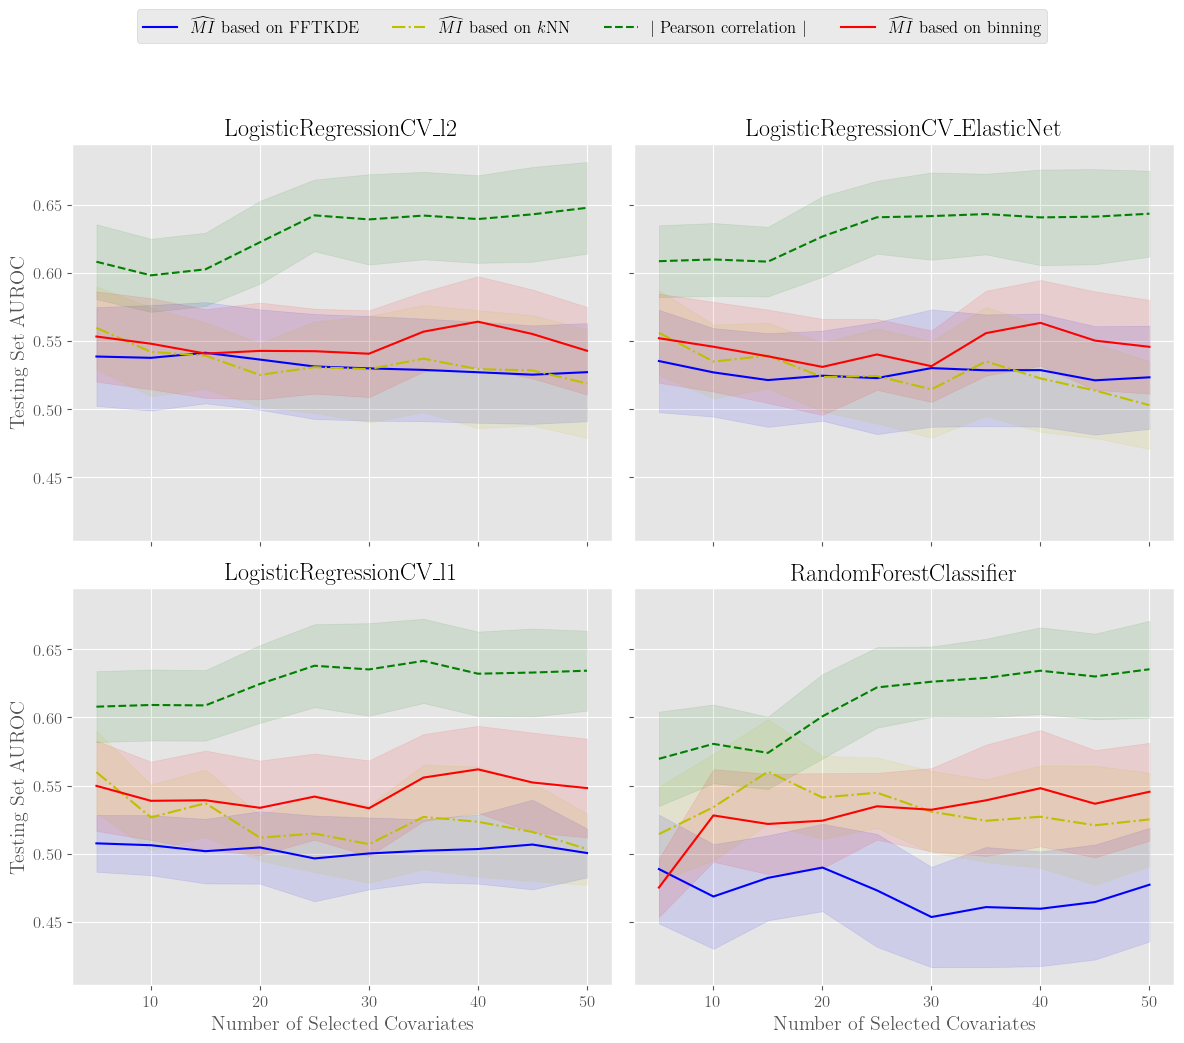

In [21]:
def plot_results(ax, fun_name, dep_measure):
    # Ensure that the necessary files exist
    if (os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))):

        # Load the data
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_binningMI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name))

        # Number of attributes for plotting
        num_attr = list(
            map(int,
                np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist()))

        # Calculate the mean and standard deviation for different methods
        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, axis=1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, axis=1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, axis=1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, axis=1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, axis=1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, axis=1)
        binningMI_fit_mean = np.mean(ABIDE_diagnosis_binningMI_foo, axis=1)
        binningMI_fit_std = np.std(ABIDE_diagnosis_binningMI_foo, axis=1)

        # Plot MI based on FFTKDE
        ax.plot(num_attr,
                MI_fit_mean,
                label=r"$\widehat{MI}$ based on FFTKDE",
                linestyle="-",
                color="b")
        ax.fill_between(
            num_attr,
            MI_fit_mean - MI_fit_std,
            MI_fit_mean + MI_fit_std,
            color="b",
            alpha=0.1,
        )

        # Plot MI based on kNN
        ax.plot(num_attr,
                skMI_fit_mean,
                label=r"$\widehat{MI}$ based on $k$NN",
                linestyle="-.",
                color="y")
        ax.fill_between(
            num_attr,
            skMI_fit_mean - skMI_fit_std,
            skMI_fit_mean + skMI_fit_std,
            color="y",
            alpha=0.1,
        )

        # Plot Pearson correlation
        ax.plot(num_attr,
                Pearson_fit_mean,
                label=r"$\vert$ Pearson correlation $\vert$",
                linestyle="--",
                color="g")
        ax.fill_between(
            num_attr,
            Pearson_fit_mean - Pearson_fit_std,
            Pearson_fit_mean + Pearson_fit_std,
            color="g",
            alpha=0.1,
        )

        # Plot MI based on binning
        ax.plot(num_attr,
                binningMI_fit_mean,
                label=r"$\widehat{MI}$ based on binning",
                linestyle="-",
                color="r")
        ax.fill_between(
            num_attr,
            binningMI_fit_mean - binningMI_fit_std,
            binningMI_fit_mean + binningMI_fit_std,
            color="r",
            alpha=0.1,
        )

        ax.set_title(fun_name)


# Prepare subplots with shared x and y axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Define the functions and dependent measure
fun_names = [
    "LogisticRegressionCV_l2", "LogisticRegressionCV_ElasticNet",
    "LogisticRegressionCV_l1", "RandomForestClassifier"
]
dep_measure = "MI_epa_ISJ"

# Plot the results in subplots
for i, fun_name in enumerate(fun_names):
    plot_results(axs[i], fun_name, dep_measure)

# Set common labels only on the outer subplots
axs[0].set_ylabel(r"Testing Set AUROC")
axs[2].set_ylabel(r"Testing Set AUROC")
axs[2].set_xlabel(r"Number of Selected Covariates")
axs[3].set_xlabel(r"Number of Selected Covariates")

# Adjust the layout and add shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper center',
           ncol=4,
           bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1,
                       0.95])  # Adjust layout to make room for the legend
plt.savefig(r"./ABIDE_predict_diagnosis/diagnosis_comparison_{}.pdf".format(
    dep_measure),
    format="pdf",
    dpi=600,
    bbox_inches='tight')  # Save figure with proper bounding box
plt.show()

### using Bernstein polynomials of degree $3$

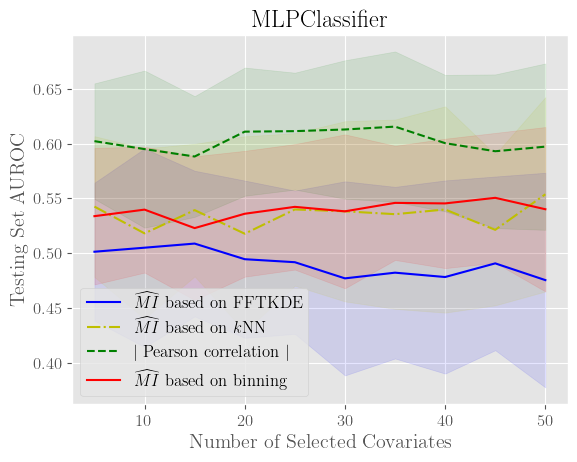

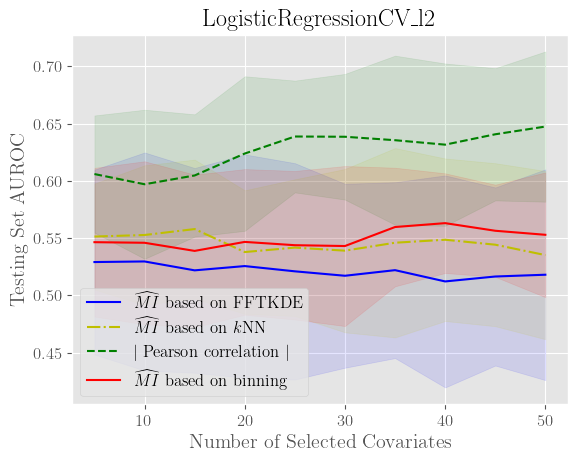

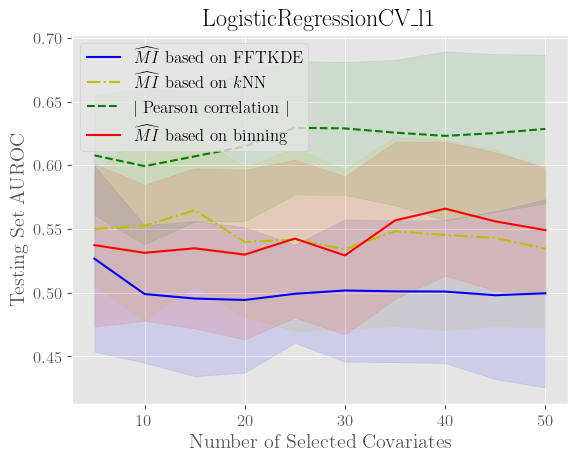

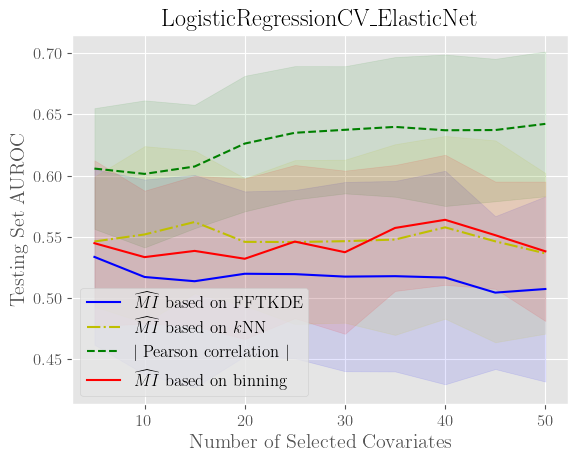

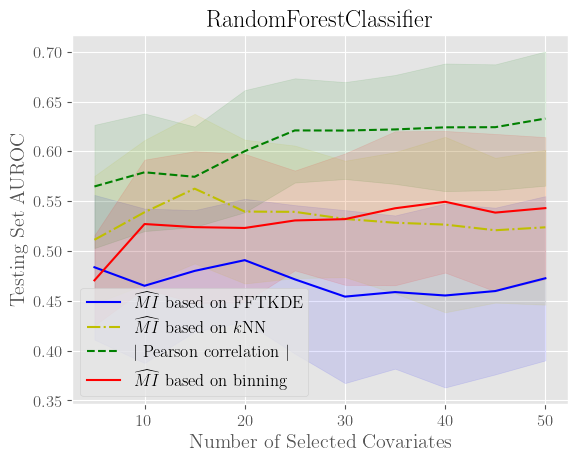

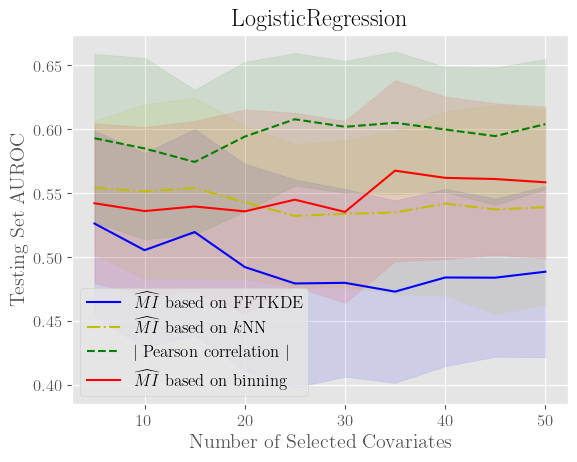

In [22]:
def plot_results(_plt, fun_name, dep_measure):
    if (os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_binningMI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, 1)
        binningMI_fit_mean = np.mean(ABIDE_diagnosis_binningMI_foo, 1)
        binningMI_fit_std = np.std(ABIDE_diagnosis_binningMI_foo, 1)

        _plt.plot(num_attr,
                  MI_fit_mean,
                  label=r"$\widehat{MI}$ based on FFTKDE",
                  linestyle="-",
                  color="b")
        _plt.fill_between(
            num_attr,
            (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
            (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
            color="b",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            skMI_fit_mean,
            label=r"$\widehat{MI}$ based on $k$NN",
            linestyle="-.",
            color="y",
        )
        _plt.fill_between(
            num_attr,
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
            (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
            color="y",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            Pearson_fit_mean,
            label=r"$\vert$ Pearson correlation $\vert$",
            linestyle="--",
            color="g",
        )
        _plt.fill_between(
            num_attr,
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=0.1,
        )

        _plt.plot(
            num_attr,
            binningMI_fit_mean,
            label=r"$\widehat{MI}$ based on binning",
            linestyle="-",
            color="r",
        )
        _plt.fill_between(
            num_attr,
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.025)),
            (binningMI_fit_mean + binningMI_fit_std * norm.ppf(0.975)),
            color="r",
            alpha=0.1,
        )

        _plt.title(fun_name)
        _plt.legend()
        plt.ylabel(r"Testing Set AUROC")
        plt.xlabel(r"Number of Selected Covariates")


dep_measure_list = []
for _kernel in [
        "gaussian",
        "exponential",
        "box",
        "tri",
        "epa",
        "biweight",
        "triweight",
        "tricube",
        "cosine",
]:
    for _bw in ["silverman", "scott", "ISJ"]:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPClassifier",
            "LogisticRegressionCV_l2",
            "LogisticRegressionCV_l1",
            "LogisticRegressionCV_ElasticNet",
            "RandomForestClassifier",
            "LogisticRegression",
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(
                r"./ABIDE_poly3_predict_diagnosis/poly3_diagnosis_" +
                fun_name + "_" + dep_measure + ".pdf",
                format="pdf",
                dpi=600,
            )
            plt.show()

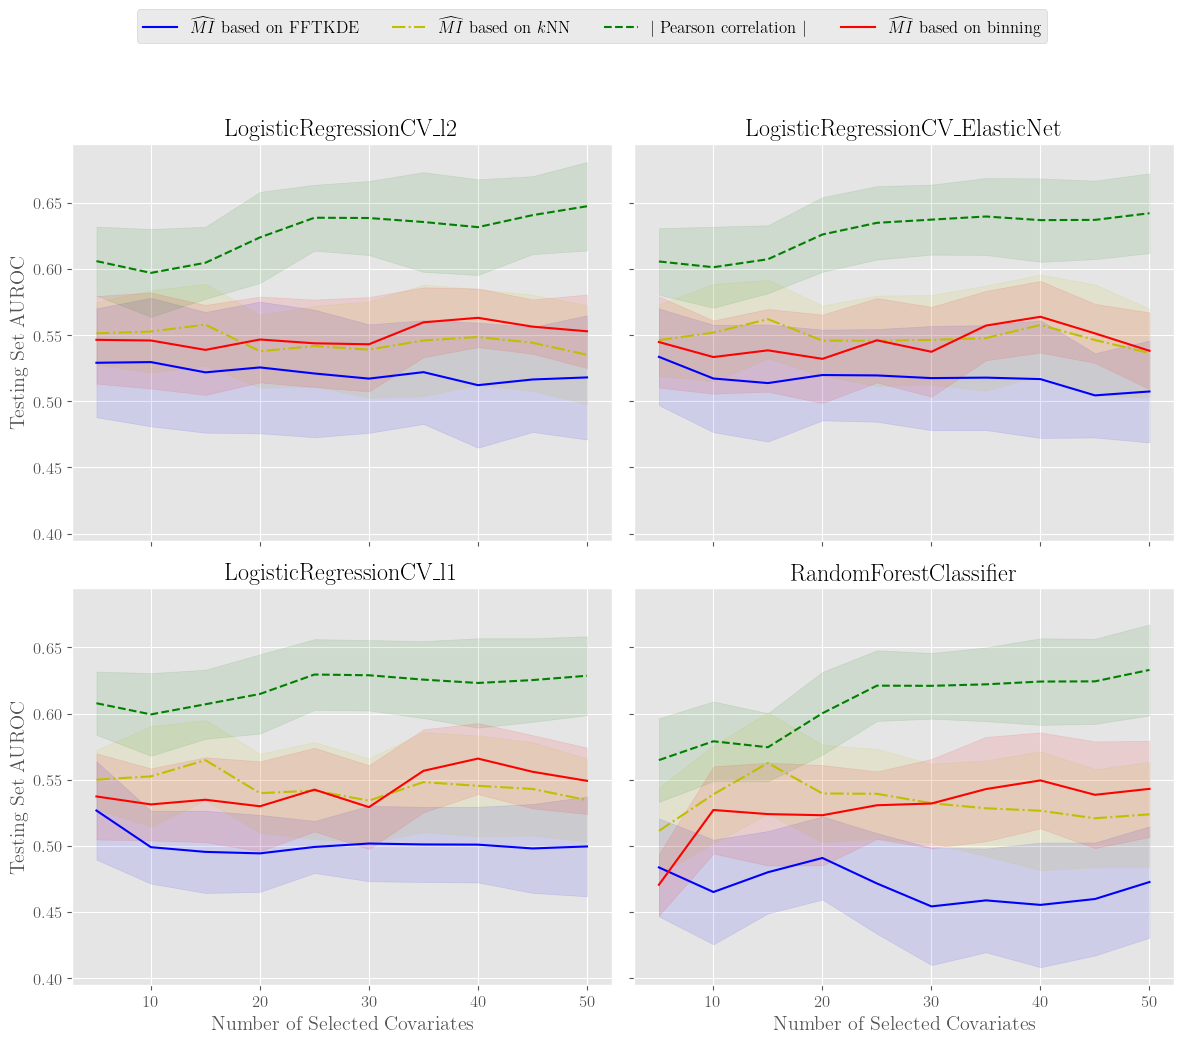

In [23]:
def plot_results(ax, fun_name, dep_measure):
    # Ensure that the necessary files exist
    if (os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))):

        # Load the data
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_binningMI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_binningMI_{fun_name}.npy"
            .format(fun_name=fun_name))

        # Number of attributes for plotting
        num_attr = list(
            map(int,
                np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist()))

        # Calculate the mean and standard deviation for different methods
        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, axis=1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, axis=1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, axis=1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, axis=1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, axis=1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, axis=1)
        binningMI_fit_mean = np.mean(ABIDE_diagnosis_binningMI_foo, axis=1)
        binningMI_fit_std = np.std(ABIDE_diagnosis_binningMI_foo, axis=1)

        # Plot MI based on FFTKDE
        ax.plot(num_attr,
                MI_fit_mean,
                label=r"$\widehat{MI}$ based on FFTKDE",
                linestyle="-",
                color="b")
        ax.fill_between(
            num_attr,
            MI_fit_mean - MI_fit_std,
            MI_fit_mean + MI_fit_std,
            color="b",
            alpha=0.1,
        )

        # Plot MI based on kNN
        ax.plot(num_attr,
                skMI_fit_mean,
                label=r"$\widehat{MI}$ based on $k$NN",
                linestyle="-.",
                color="y")
        ax.fill_between(
            num_attr,
            skMI_fit_mean - skMI_fit_std,
            skMI_fit_mean + skMI_fit_std,
            color="y",
            alpha=0.1,
        )

        # Plot Pearson correlation
        ax.plot(num_attr,
                Pearson_fit_mean,
                label=r"$\vert$ Pearson correlation $\vert$",
                linestyle="--",
                color="g")
        ax.fill_between(
            num_attr,
            Pearson_fit_mean - Pearson_fit_std,
            Pearson_fit_mean + Pearson_fit_std,
            color="g",
            alpha=0.1,
        )

        # Plot MI based on binning
        ax.plot(num_attr,
                binningMI_fit_mean,
                label=r"$\widehat{MI}$ based on binning",
                linestyle="-",
                color="r")
        ax.fill_between(
            num_attr,
            binningMI_fit_mean - binningMI_fit_std,
            binningMI_fit_mean + binningMI_fit_std,
            color="r",
            alpha=0.1,
        )

        ax.set_title(fun_name)


# Prepare subplots with shared x and y axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Define the functions and dependent measure
fun_names = [
    "LogisticRegressionCV_l2", "LogisticRegressionCV_ElasticNet",
    "LogisticRegressionCV_l1", "RandomForestClassifier"
]
dep_measure = "MI_epa_ISJ"

# Plot the results in subplots
for i, fun_name in enumerate(fun_names):
    plot_results(axs[i], fun_name, dep_measure)

# Set common labels only on the outer subplots
axs[0].set_ylabel(r"Testing Set AUROC")
axs[2].set_ylabel(r"Testing Set AUROC")
axs[2].set_xlabel(r"Number of Selected Covariates")
axs[3].set_xlabel(r"Number of Selected Covariates")

# Adjust the layout and add shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper center',
           ncol=4,
           bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1,
                       0.95])  # Adjust layout to make room for the legend

plt.savefig(
    r"./ABIDE_poly3_predict_diagnosis/poly3_diagnosis_comparison_{}.pdf".
    format(dep_measure),
    format="pdf",
    dpi=600,
    bbox_inches='tight'
)  # Ensure the entire plot and legend are included in the saved file

plt.show()

In [24]:
# format the code a bit
# !find . -name "*.py" -exec isort "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place " {}" \;

!find . -name "*.py" -exec isort "{}" \;
!find . -name "*.py" -exec yapf --in-place "{}" \;
!find . -name "*.py" -exec autopep8 --in-place " {}" \;

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_clump.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_tri_ISJ_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_cosine_ISJ_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_box_ISJ_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_box_silverman_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_gaussian_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_gaussian_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_exponential_scott_RidgeCV.py
Fixing 

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_gaussian_ISJ_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_biweight_ISJ_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_tricube_silverman_RandomForestRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_gaussian_scott_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_gaussian_ISJ_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_tri_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_box_ISJ_RandomForestRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_pr

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_box_scott_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_box_silverman_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_triweight_scott_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_biweight_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_tricube_silverman_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_biweight_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_epa_ISJ_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_epa_scott_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_epa_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_skMI_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_exponential_ISJ_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_tricube_silverman_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_triweight_scott_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_age/ABIDE_age_MI_epa_silverman_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABI

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_nonlinear/ABIDE_sim_binary_original_40.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_nonlinear/ABIDE_sim_binary_original_160.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_nonlinear/ABIDE_sim_continuous_40.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_nonlinear/ABIDE_sim_continuous_160.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_nonlinear/ABIDE_sim_continuous_120.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_nonlinear/ABIDE_sim_binary_original_120.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_screening_age_share_mem.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_scott_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_ISJ_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_silverman_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_box_silverman_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_ISJ_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_anal

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_biweight_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_silverman_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_cosine_scott_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_silverman_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_biweight_scott_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_scott_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_dat

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_ISJ_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_ISJ_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_scott_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_scott_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_predict_diagnosis/ABIDE_diagnosis_sk

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_binningMI_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_silverman_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_ISJ_L

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_ISJ_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_scott_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_silverman_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_scott_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_ISJ_LassoCV.py
Fixing /Users

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_ISJ_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_scott_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_scott_RandomFore

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_scott_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_ISJ_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_silverman_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_silverman_

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_scott_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_exponential_silverman_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_scott_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_exponential_scott_LogisticRegressionCV_l1.p

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_silverman_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_silverman_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_scott_LogisticRegressionCV_ElasticNet.p

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tri_ISJ_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_scott_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_triweight_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Use

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_silverman_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_ISJ_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_silverman_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tri_silverman_RandomForestClassifier.py
Fixing /Users/alphai

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_scott_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_ISJ_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_scott_RandomForestRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_silverman_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_gaussian_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_scott_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_scott_ElasticNetCV.py
Fixing /

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_silverman_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_cosine_silverman_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_cosine_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_scott_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_silverman_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_ISJ_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_scott_RidgeCV.py
Fixing /Users/al

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_scott_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_scott_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_silverman_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_gaussian_silverman_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_ISJ_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_silverman_RidgeCV.py
Fixin

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_skMI_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_skMI_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tri_scott_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_scott_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_scott_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_triweight_ISJ_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_silverman_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/pape

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_scott_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_biweight_scott_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_scott_RandomForestClassifier.py
Fixin

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_box_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_biweight_scott_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_biweight_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_scott_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_scott_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_biweight_scott_LogisticRegressionCV_l1.py
Fix

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_scott_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_cosine_scott_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_ISJ_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_scott_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_scott_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_scott_LogisticRegressionCV_l1.py
Fixing 

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_scott_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_silverman_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_scott_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_scott_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_silverman_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PC

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_scott_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_scott_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_scott_RandomForestRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_ISJ_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_scott_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_scott_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_silverman_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_silverman_MLPRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_silverman_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_silverman_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_ISJ_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_scott_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_silverman_RidgeCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_scott_LarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_ISJ_RandomForestRegressor.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/A

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_silverman_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_silverman_LassoCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_scott_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_ISJ_LinearRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_ElasticNetCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_LassoLarsCV.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_ISJ_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_silverman_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_ISJ_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_scott_LogisticRegressionCV_ElasticNet.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_ISJ_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosi

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_triweight_scott_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_ISJ_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_scott_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_scott_LogisticRegressionCV_l2.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_ISJ_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_ISJ_MLPClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_triweight_silverman_LogisticRegression.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_LogisticRegressionCV_l1.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tri_scott_RandomForestClassifier.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biwei

Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_translated_40.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_original_80.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_translated_160.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_translated_80.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_translated_120.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_original_40.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulations_linear/ABIDE_sim_binary_original_160.py
Fixing /Users/alphaito/Documents/Github/MI_AG/paper/ABIDE_data_analysis/ABIDE_simulati

[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_gaussian_ISJ_LarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_tri_scott_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_box_ISJ_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_cosine_silverman_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_box_scott_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_exponential_scott_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_cosine_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_tri_ISJ_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_tricube_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_triweight_I

[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_biweight_silverman_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_epa_ISJ_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_epa_scott_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_exponential_scott_LarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_exponential_silverman_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_binningMI_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_Pearson_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_binningMI_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_gaussian_scott_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_M

[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_triweight_silverman_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_epa_silverman_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_biweight_scott_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_triweight_ISJ_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_tri_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_biweight_ISJ_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_Pearson_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_epa_ISJ_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_tri_silverman_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_age/ABIDE_age_MI_biweight_s

[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_scott_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_box_silverman_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_scott_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_silverman_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_scott_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_ISJ_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_silverman_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tr

[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_scott_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_ISJ_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_silverman_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_box_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_ISJ_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_scott_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_ISJ_LogisticR

[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_ISJ_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_box_scott_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_screening_diagnosis_high_mem.py'
[Errno 2] No such file or directory: ' ./ABIDE_screening_age_dask.py'
[Errno 2] No such file or directory: ' ./running_speed/speed_comparison_age_high_mem.py'
[Errno 2] No such file or directory: ' ./running_speed/speed_comparison_age_share_mem.py'
[Errno 2] No such file or directory: ' ./running_speed/speed_comparison_diagnosis_high_mem.py'
[Errno 2] No such file or directory: ' ./running_speed/speed_comparison_diagnosis_share_mem.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_silverman_LinearRegression.py'
[E

[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_scott_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_scott_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_ISJ_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_ISJ_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_ISJ_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_scott_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_box_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_ag

[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_ISJ_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_scott_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_a

[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_scott_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_silverman_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_ISJ_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_ISJ_LarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_ISJ_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_ISJ_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_ISJ_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_silverman_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_

[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_silverman_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_ISJ_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_silverman_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_binningMI_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_ISJ_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_scott_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly

[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_scott_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_exponential_silverman_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_ISJ_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_scott_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_exponential_ISJ_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tri_ISJ_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_pred

[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_scott_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_scott_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_silverman_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_scott_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_triweight_scott_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_silverman_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_scott_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_ISJ_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_cosine_silverman_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_cosine_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_exponential_ISJ_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_exponential_scott_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_exponential_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_Pearson

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_Pearson_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_Pearson_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_scott_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_silverman_LarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_silverman_LassoLarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_triweight_scott_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_silverman_LassoCV.py'
[Errno 2] No su

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tri_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_triweight_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_epa_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tri_scott_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_biweight_scott_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tri_scott_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_tricube_ISJ_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_age/ABIDE_age_MI_box_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_ISJ_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_ISJ_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_triweight_scott_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABI

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_silverman_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_ISJ_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_cosine_ISJ_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_silverman_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_scott_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_ISJ_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_silverman_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagn

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_silverman_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_epa_ISJ_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_gaussian_ISJ_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tri_ISJ_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_exponential_ISJ_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_MI_tricube_scott_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_predict_diagnosis/ABIDE_diagnosis_

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_scott_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_silverman_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_silverman_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_ISJ_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_ISJ_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_ISJ_RandomForestRe

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_silverman_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_triweight_scott_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_gaussian_ISJ_LinearRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_scott_RidgeCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_cosine_scott_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_scott_ElasticNetCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_ISJ_MLPRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_ISJ_LassoCV.py'
[Errno 2] No 

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_biweight_scott_LarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_ISJ_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_epa_silverman_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_scott_LarsCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tri_scott_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_tricube_scott_LassoCV.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_silverman_RandomForestRegressor.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_age/ABIDE_poly3_age_MI_exponential_ISJ_RidgeCV.py'
[Errno 2] No 

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tri_scott_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_ISJ_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_ISJ_RandomForestClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_epa_silverman_LogisticRegression

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_LogisticRegressionCV_l1.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tricube_silverman_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_ISJ_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_box_scott_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_silverman_LogisticRegressionCV_l2.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_tri_scott_M

[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_gaussian_ISJ_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_biweight_scott_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_exponential_scott_LogisticRegression.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_scott_LogisticRegressionCV_ElasticNet.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_scott_MLPClassifier.py'
[Errno 2] No such file or directory: ' ./ABIDE_PCA/ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_MI_cosine_silverman_LogisticRe

[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_continuous_200.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_original_200.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_continuous_80.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_translated_200.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_translated_40.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_original_80.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_translated_160.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_translated_80.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_translated_120.py'
[Errno 2] No such file or directory: ' ./ABIDE_simulations_linear/ABIDE_sim_binary_original_40.py'
[Errn